# Telecom Churn Prediction


#### Problem Statement:

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate.
Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.


In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# work with plotly
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.subplots as tls # It's useful to we get some tools of plotly

from collections import Counter # To do counter of some features
import plotly.io as pio


# Supress warnings
warnings.filterwarnings('ignore')

## Content

1. [Reading,Understanding and cleaning data](#)
2. [Filter high value customers](#)
3. [Outlier Treatment](#)
4. [Exploratory Data Analysis/Data Visualization](#)
    1. [Univariate Analysis](#)
    2. [Deriving new features](#)
    3. [Multivariate Analysis](#)
5. [Data Preparation](#)
6. [Splitting the Data into Training and Testing Sets](#)
7. [Model Building and Evaluation](#)
    1. [PCA and Logistic Regression](#)
    2. [](#)
    3. [Lasso Regression to determine important features](#)
8. [Observations](#)
9. [Top features](#)

## 1. Reading, Understanding and Cleaning the data

In [2]:
# Reading the train data set

Telecom_df = pd.read_csv('train.csv')

In [3]:
#Summary of the data set

Telecom_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

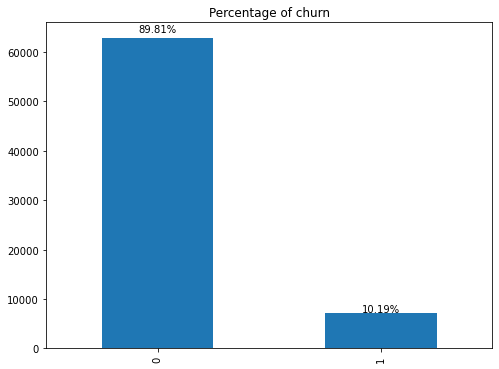

In [4]:
#Percentage of churn in the current data

plt.title("Percentage of churn")
ax = Telecom_df["churn_probability"].value_counts().plot.bar(figsize=[8,6])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{round(height/len(Telecom_df["churn_probability"])*100, 2)}%', xy=(x + width/2, y + height*1.02), ha='center')
plt.show()

In [5]:
#Checking for unwanted rows

Telecom_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [6]:
Telecom_df.tail()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
69994,69994,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,15.760,410.924,...,1,0,NaN,1.0,1.0,221,0.00,0.00,0.00,0
69995,69995,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,160.083,289.129,...,0,0,NaN,NaN,NaN,712,0.00,0.00,0.00,0
69996,69996,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,372.088,258.374,...,0,0,NaN,NaN,NaN,879,0.00,0.00,0.00,0
69997,69997,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,238.575,245.414,...,0,0,1.0,1.0,1.0,277,664.25,1402.96,990.97,0
69998,69998,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,168.269,42.815,...,0,0,1.0,NaN,1.0,1876,0.00,0.00,0.00,0


- There is no Incorrect rows - Header rows, footer rows
- There is no Summary rowsTotal, subtotal rows
- There is no Extra rows,Column numbers, indicators, blank rows

In [7]:
# checking for wrong columns names, missing columns etc.

for i in Telecom_df.columns:
    print(i)

id
circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
arpu_6
arpu_7
arpu_8
onnet_mou_6
onnet_mou_7
onnet_mou_8
offnet_mou_6
offnet_mou_7
offnet_mou_8
roam_ic_mou_6
roam_ic_mou_7
roam_ic_mou_8
roam_og_mou_6
roam_og_mou_7
roam_og_mou_8
loc_og_t2t_mou_6
loc_og_t2t_mou_7
loc_og_t2t_mou_8
loc_og_t2m_mou_6
loc_og_t2m_mou_7
loc_og_t2m_mou_8
loc_og_t2f_mou_6
loc_og_t2f_mou_7
loc_og_t2f_mou_8
loc_og_t2c_mou_6
loc_og_t2c_mou_7
loc_og_t2c_mou_8
loc_og_mou_6
loc_og_mou_7
loc_og_mou_8
std_og_t2t_mou_6
std_og_t2t_mou_7
std_og_t2t_mou_8
std_og_t2m_mou_6
std_og_t2m_mou_7
std_og_t2m_mou_8
std_og_t2f_mou_6
std_og_t2f_mou_7
std_og_t2f_mou_8
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_mou_6
std_og_mou_7
std_og_mou_8
isd_og_mou_6
isd_og_mou_7
isd_og_mou_8
spl_og_mou_6
spl_og_mou_7
spl_og_mou_8
og_others_6
og_others_7
og_others_8
total_og_mou_6
total_og_mou_7
total_og_mou_8
loc_ic_t2t_mou_6
loc_ic_t2t_mou_7
loc_ic_t2t_mou_8
loc

- There is no missing columns observed
- There is no Inconsistent column names
- No Unique Identifier
- No Misaligned columns
- There is no Columns containing Multiple data values

### Dropping unwanted columns

In [8]:
# Columns having same value across all records hence droping these

for i in Telecom_df.columns[Telecom_df.nunique() <= 1]:
    print(Telecom_df[i].value_counts())

109    69999
Name: circle_id, dtype: int64
0.0    69297
Name: loc_og_t2o_mou, dtype: int64
0.0    69297
Name: std_og_t2o_mou, dtype: int64
0.0    69297
Name: loc_ic_t2o_mou, dtype: int64
6/30/2014    69999
Name: last_date_of_month_6, dtype: int64
7/31/2014    69600
Name: last_date_of_month_7, dtype: int64
8/31/2014    69266
Name: last_date_of_month_8, dtype: int64
0.0    67231
Name: std_og_t2c_mou_6, dtype: int64
0.0    67312
Name: std_og_t2c_mou_7, dtype: int64
0.0    66296
Name: std_og_t2c_mou_8, dtype: int64
0.0    67231
Name: std_ic_t2o_mou_6, dtype: int64
0.0    67312
Name: std_ic_t2o_mou_7, dtype: int64
0.0    66296
Name: std_ic_t2o_mou_8, dtype: int64


In [9]:
Telecom_df.shape

(69999, 172)

In [10]:
# Dropping columns with signle value

DropCol = Telecom_df.columns[Telecom_df.nunique() <= 1].to_frame().index
Telecom_df.drop(DropCol,axis=1,inplace=True)

In [11]:
Telecom_df.shape

(69999, 159)

In [12]:
# 'Id' doesn't add any value since dropping the same

Telecom_df.drop(['id'],axis=1,inplace=True)

In [13]:
# There are no duplicate records

Telecom_df[Telecom_df.duplicated()]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability


### Null value treatment

In [14]:
# Checking the number of missing values and its percentage
missing_values_count = Telecom_df.isnull().sum().sort_values(ascending = False)
missing_values_perc = (100*Telecom_df.isnull().sum()/Telecom_df.shape[0]).sort_values(ascending = False)
df_missing_values = pd.concat([missing_values_count,missing_values_perc], axis=1, keys=['Missing Values', 'Missing Values %'])
df_missing_values[df_missing_values['Missing Values %']>50]

,Missing Values,Missing Values %
av_rech_amt_data_6,52431,74.902499
count_rech_3g_6,52431,74.902499
arpu_3g_6,52431,74.902499
arpu_2g_6,52431,74.902499
max_rech_data_6,52431,74.902499
night_pck_user_6,52431,74.902499
count_rech_2g_6,52431,74.902499
date_of_last_rech_data_6,52431,74.902499
total_rech_data_6,52431,74.902499
fb_user_6,52431,74.902499


In [15]:
#columns where we will impute missing values with zeroes

zero_impute = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8','av_rech_amt_data_6', 
               'av_rech_amt_data_7', 'av_rech_amt_data_8','max_rech_data_6', 'max_rech_data_7', 
               'max_rech_data_8','night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6',
              'fb_user_7','fb_user_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8',
              'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7',
               'count_rech_3g_8']

# impute missing values with 0
Telecom_df[zero_impute] = Telecom_df[zero_impute].apply(lambda x: x.fillna(0))

In [16]:
#Columns where we will impute missing values with median
#All null values for onnet and offnet minutes of usage voice calls has been replaced 
#with median to keep the distribution

mou = ['onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8']
Telecom_df[mou] = Telecom_df[mou].apply(lambda x: x.fillna(x.median()))

In [17]:
#Columns where we will impute missing values with median
#All null values for outgoing and incoming minutes of usage voice calls has been replaced 
#with median to keep the distribution
ogicarray = []
for i in Telecom_df.columns:
    if 'og' in i or 'ic' in i:
        ogicarray.append(i)
    
for i in ogicarray:
    print(i)
print(len(ogicarray))

Telecom_df[ogicarray] = Telecom_df[ogicarray].apply(lambda x: x.fillna(x.median()))

roam_ic_mou_6
roam_ic_mou_7
roam_ic_mou_8
roam_og_mou_6
roam_og_mou_7
roam_og_mou_8
loc_og_t2t_mou_6
loc_og_t2t_mou_7
loc_og_t2t_mou_8
loc_og_t2m_mou_6
loc_og_t2m_mou_7
loc_og_t2m_mou_8
loc_og_t2f_mou_6
loc_og_t2f_mou_7
loc_og_t2f_mou_8
loc_og_t2c_mou_6
loc_og_t2c_mou_7
loc_og_t2c_mou_8
loc_og_mou_6
loc_og_mou_7
loc_og_mou_8
std_og_t2t_mou_6
std_og_t2t_mou_7
std_og_t2t_mou_8
std_og_t2m_mou_6
std_og_t2m_mou_7
std_og_t2m_mou_8
std_og_t2f_mou_6
std_og_t2f_mou_7
std_og_t2f_mou_8
std_og_mou_6
std_og_mou_7
std_og_mou_8
isd_og_mou_6
isd_og_mou_7
isd_og_mou_8
spl_og_mou_6
spl_og_mou_7
spl_og_mou_8
og_others_6
og_others_7
og_others_8
total_og_mou_6
total_og_mou_7
total_og_mou_8
loc_ic_t2t_mou_6
loc_ic_t2t_mou_7
loc_ic_t2t_mou_8
loc_ic_t2m_mou_6
loc_ic_t2m_mou_7
loc_ic_t2m_mou_8
loc_ic_t2f_mou_6
loc_ic_t2f_mou_7
loc_ic_t2f_mou_8
loc_ic_mou_6
loc_ic_mou_7
loc_ic_mou_8
std_ic_t2t_mou_6
std_ic_t2t_mou_7
std_ic_t2t_mou_8
std_ic_t2m_mou_6
std_ic_t2m_mou_7
std_ic_t2m_mou_8
std_ic_t2f_mou_6
std_ic_t2f_

In [18]:
# Handling dates columns
dates = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
         'date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']

In [19]:
# checking for null values post treatment

Telecom_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 158 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    arpu_6                    69999 non-null  float64
 1    arpu_7                    69999 non-null  float64
 2    arpu_8                    69999 non-null  float64
 3    onnet_mou_6               69999 non-null  float64
 4    onnet_mou_7               69999 non-null  float64
 5    onnet_mou_8               69999 non-null  float64
 6    offnet_mou_6              69999 non-null  float64
 7    offnet_mou_7              69999 non-null  float64
 8    offnet_mou_8              69999 non-null  float64
 9    roam_ic_mou_6             69999 non-null  float64
 10   roam_ic_mou_7             69999 non-null  float64
 11   roam_ic_mou_8             69999 non-null  float64
 12   roam_og_mou_6             69999 non-null  float64
 13   roam_og_mou_7             69999 non-null  fl

- No null values found

## 2. Filter high value customers

In [20]:
# calculate the total data recharge amount for June and July --> number of recharges * average recharge amount
Telecom_df['total_data_rech_6'] = Telecom_df.total_rech_data_6 * Telecom_df.av_rech_amt_data_6
Telecom_df['total_data_rech_7'] = Telecom_df.total_rech_data_7 * Telecom_df.av_rech_amt_data_7

In [21]:
# calculate total recharge amount for June and July --> call recharge amount + data recharge amount
Telecom_df['amt_data_6'] = Telecom_df.total_rech_amt_6 + Telecom_df.total_data_rech_6
Telecom_df['amt_data_7'] = Telecom_df.total_rech_amt_7 + Telecom_df.total_data_rech_7

In [22]:
# calculate average recharge done by customer in June and July
Telecom_df['av_amt_data_6_7'] = (Telecom_df.amt_data_6 + Telecom_df.amt_data_7)/2

In [23]:
# look at the 70th percentile recharge amount
print("Recharge amount at 70th percentile: {0}".format(Telecom_df.av_amt_data_6_7.quantile(0.7)))

Recharge amount at 70th percentile: 477.5


In [24]:
# retain only those customers who have recharged their mobiles with more than or equal to 70th percentile amount
Telecom_df_filtered = Telecom_df.loc[Telecom_df.av_amt_data_6_7 >= Telecom_df.av_amt_data_6_7.quantile(0.7), :]
Telecom_df_filtered = Telecom_df_filtered.reset_index(drop=True)
Telecom_df_filtered.shape

(21013, 163)

In [25]:
# delete variables created to filter high-value customers
Telecom_df_filtered = Telecom_df_filtered.drop(['total_data_rech_6', 'total_data_rech_7',
                                      'amt_data_6', 'amt_data_7', 'av_amt_data_6_7'], axis=1)
Telecom_df_filtered.shape

(21013, 158)

## 3. Outlier treatment

In [26]:
# determinining numeric columns by avoiding those columns with 
# less than or equal to 2 unique values (as these can be considered as catergorical ) and the date fields

numeric_cols = []
for i in Telecom_df_filtered.columns[Telecom_df_filtered.nunique() > 2]:
    if('date' not in i ):
        numeric_cols.append(i)
print(len(numeric_cols))

145


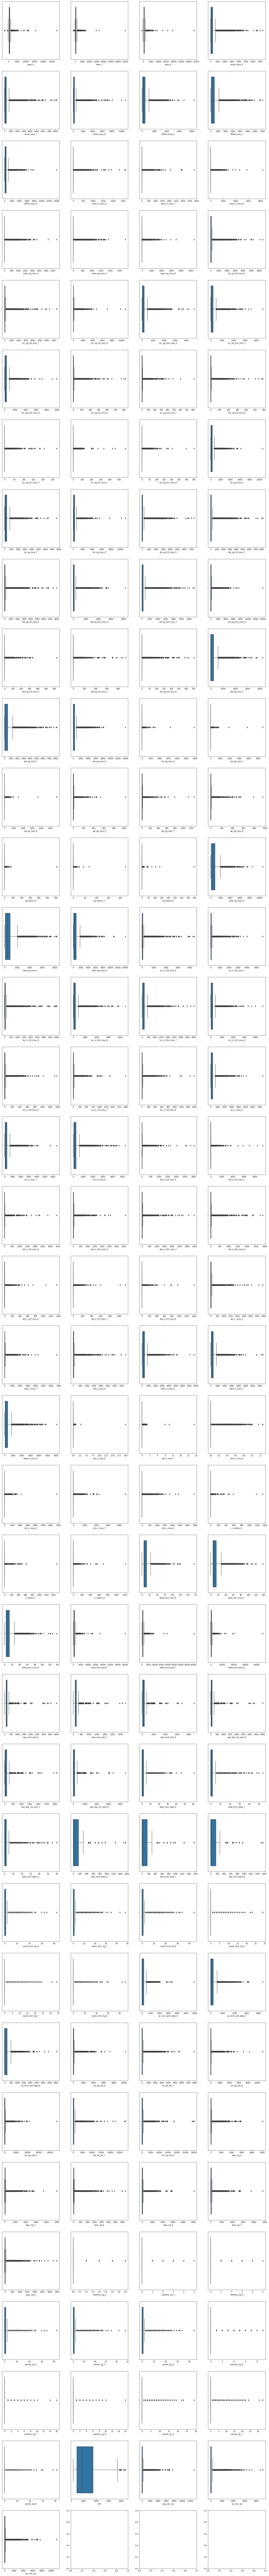

In [27]:
# Box plot to check outliers on numeric columns

fig, axs = plt.subplots(37,4,figsize=(25,250))
j=0
for i in numeric_cols:
    if(j>=4):
        k=j%4
    else:
        k=j
    sns.boxplot(Telecom_df_filtered[i],ax=axs[j//4][k])
    j+=1
fig.show()

In [28]:
# Shape before treating outlier

Telecom_df_filtered.shape

(21013, 158)

#### On checking the outliers from the box plot, removing the outliers using a generic rule for all columns will not work since for each columns the outliers are lying at different percentile, hence the decision was take to remove outlier for some key columns as below.

In [29]:
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_6']<6000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_7']<15000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_8']<8000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['offnet_mou_6']<6000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['offnet_mou_7']<6000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['offnet_mou_8']<6000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['roam_ic_mou_6']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['roam_ic_mou_7']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['roam_ic_mou_8']<4000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['roam_og_mou_6']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['roam_og_mou_7']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['roam_og_mou_7']<2500]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2t_mou_6']<4500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2t_mou_7']<4500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2t_mou_8']<3800]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2m_mou_6']<3000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2m_mou_7']<3000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2m_mou_8']<2300]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2f_mou_6']<500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2f_mou_7']<400]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2f_mou_8']<400]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2c_mou_6']<170]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2c_mou_7']<250]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_t2c_mou_8']<250]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_mou_6']<5000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_mou_7']<7000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_og_mou_8']<6000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_og_t2t_mou_6']<5000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_og_t2t_mou_7']<6000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_og_t2t_mou_8']<6000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_og_t2f_mou_6']<400]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_og_t2f_mou_7']<300]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_og_t2f_mou_8']<250]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['isd_og_mou_6']<1000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['isd_og_mou_8']<800]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['spl_og_mou_6']<500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['spl_og_mou_7']<500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['spl_og_mou_8']<600]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['og_others_6']<30]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['og_others_7']<15]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['og_others_8']<12]

##########################################################

#Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2t_mou_6']<4500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2t_mou_7']<4500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2t_mou_8']<4500]

#Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2m_mou_6']<3000]
#Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2m_mou_7']<3000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2m_mou_8']<4000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2f_mou_6']<1200]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2f_mou_7']<1200]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_t2f_mou_8']<1200]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_mou_6']<6000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_mou_7']<6000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['loc_ic_mou_8']<8000]

#Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2t_mou_6']<5000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2t_mou_7']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2t_mou_8']<2500]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2m_mou_6']<3000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2m_mou_7']<4000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2m_mou_8']<3500]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2f_mou_6']<800]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2f_mou_7']<600]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['std_ic_t2f_mou_8']<600]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['isd_ic_mou_6']<4000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['isd_ic_mou_7']<4000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['isd_ic_mou_8']<3000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['spl_ic_mou_6']<1]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['spl_ic_mou_7']<1.25]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['spl_ic_mou_8']<1.25]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['ic_others_6']<600]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['ic_others_7']<500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['ic_others_8']<800]

#############################################################################

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['total_rech_num_6']<100]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['total_rech_num_6']<90]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['total_rech_num_6']<100]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['max_rech_amt_6']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['max_rech_amt_7']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['max_rech_amt_8']<2500]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['last_day_rch_amt_6']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['last_day_rch_amt_7']<1250]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['last_day_rch_amt_8']<2500]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['total_rech_data_6']<35]
#Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['total_rech_data_7']<500]
#Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['total_rech_data_8']<800]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['max_rech_data_6']<1000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['max_rech_data_7']<1000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['max_rech_data_8']<1000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['count_rech_2g_6']<35]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['count_rech_2g_7']<30]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['count_rech_2g_8']<35]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['count_rech_3g_6']<25]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['count_rech_3g_7']<25]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['count_rech_3g_8']<30]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['av_rech_amt_data_6']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['av_rech_amt_data_7']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['av_rech_amt_data_8']<2500]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['vol_2g_mb_6']<8000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['vol_2g_mb_7']<6000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['vol_2g_mb_8']<8000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['vol_3g_mb_6']<15000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['vol_3g_mb_7']<15000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['vol_3g_mb_8']<14000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_2g_6']<3000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_2g_7']<2000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_2g_8']<2000]

Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_3g_6']<2500]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_3g_7']<2000]
Telecom_df_filtered = Telecom_df_filtered[Telecom_df_filtered['arpu_3g_8']<2000]


In [30]:
# shape post outlier treatment
Telecom_df_filtered.shape

(20764, 158)

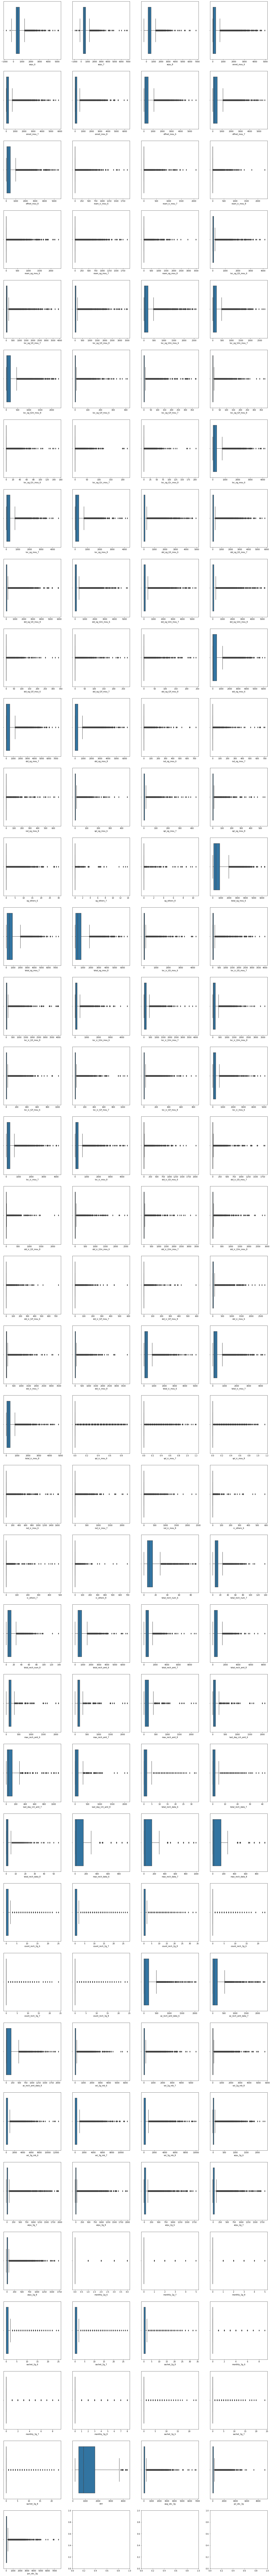

In [31]:
# observing the data after outlier treatment

fig, axs = plt.subplots(37,4,figsize=(25,250))
j=0
for i in numeric_cols:
    if(j>=4):
        k=j%4
    else:
        k=j
    sns.boxplot(Telecom_df_filtered[i],ax=axs[j//4][k])
    j+=1
fig.show()

- After outlier treatment most of the outliers from the key columns have been removed.

## 4. Exploratory Data Analysis/Data Visualization

In [32]:
#Number of churn in the current data representing high value customers

tr0 = go.Bar(
            x = Telecom_df_filtered[Telecom_df_filtered["churn_probability"]== 1]["churn_probability"].value_counts().index.values,
            y = Telecom_df_filtered[Telecom_df_filtered["churn_probability"]== 1]["churn_probability"].value_counts().values,
            name='Churned'
    )

tr1 = go.Bar(
            x = Telecom_df_filtered[Telecom_df_filtered["churn_probability"]== 0]["churn_probability"].value_counts().index.values,
            y = Telecom_df_filtered[Telecom_df_filtered["churn_probability"]== 0]["churn_probability"].value_counts().values,
            name='Not Churned'
    )

data = [tr0, tr1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='churn_probability Variable'
    ),
    title='Chrun probability variable distribution'
)

fig = go.Figure(data=data, layout=layout)


py.iplot(fig, filename='grouped-bar')

### A. Univariate Analysis

In [33]:
# quantitative variables
print(len(numeric_cols))

145


In [34]:
# Spliting the numeric columns into outgoing, incoming, data and others related columns for analysis

ogCols = []
icCols = []
dataCols = []
otherCols = []
for i in numeric_cols:
    if 'og' in i:
        ogCols.append(i)
    elif 'ic' in i:
        icCols.append(i)
    elif 'data' in i or '2g' in i or '3g' in i:
        dataCols.append(i)
    else:
        otherCols.append(i)

print(len(ogCols))
print(len(icCols))
print(len(dataCols))
print(len(otherCols))
    

42
39
42
22


#### We will visualize the distribution each feature using histogram

#### Outgoing call minutes analysis

<AxesSubplot:xlabel='roam_og_mou_6', ylabel='Count'>

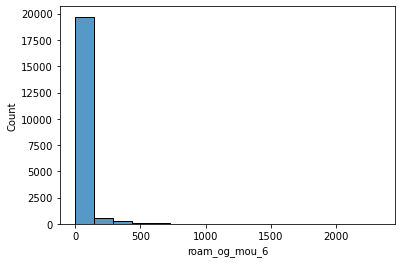

In [35]:
sns.histplot(Telecom_df_filtered['roam_og_mou_6'])

Total Sum for 6 = 556604.55
Total Sum for 7 = 413978.74
Total Sum for 8 = 389748.66


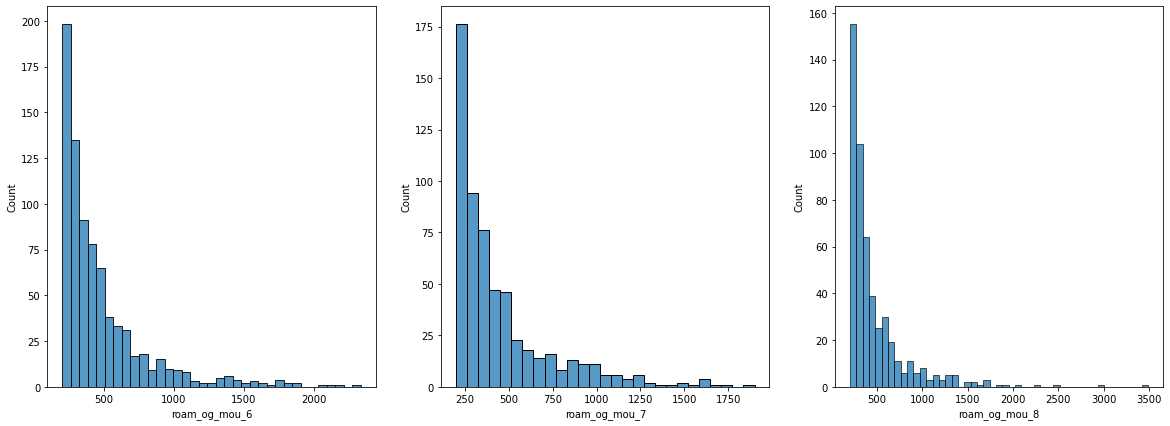

In [36]:
# roaming outgoing minutes greater than 200 as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['roam_og_mou_6']>=200.0]['roam_og_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['roam_og_mou_7']>=200.0]['roam_og_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['roam_og_mou_8']>=200.0]['roam_og_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['roam_og_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['roam_og_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['roam_og_mou_8'].sum()))

- Total roaming outgoing call reduced for month 7 and 8 compared to month 6

Total Sum for 6 = 1696063.98
Total Sum for 7 = 1706919.2300000002
Total Sum for 8 = 1548834.3699999999


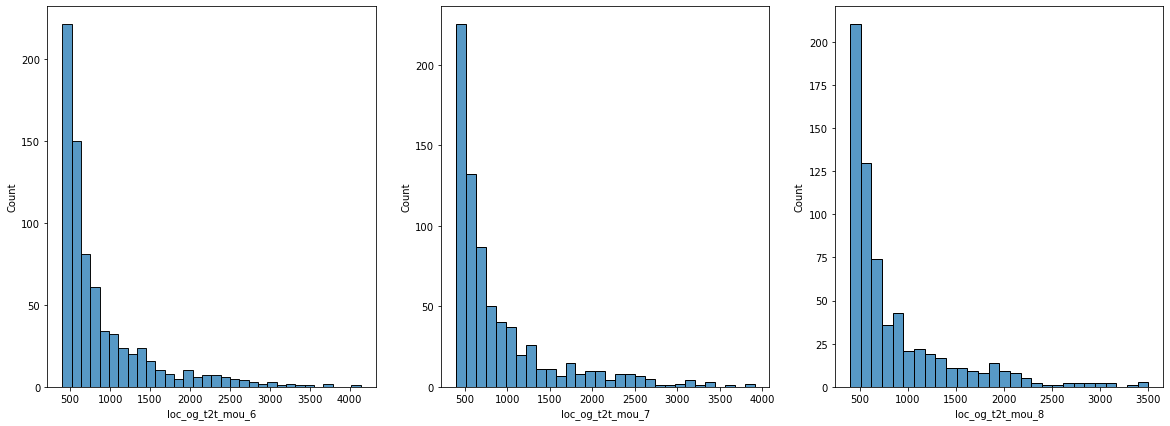

In [37]:
# loc_og_t2t_mou greater than 400, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2t_mou_6']>=400.0]['loc_og_t2t_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2t_mou_7']>=400.0]['loc_og_t2t_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2t_mou_8']>=400.0]['loc_og_t2t_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['loc_og_t2t_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['loc_og_t2t_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['loc_og_t2t_mou_8'].sum()))

- Here we can see a sligh increase from month 6 to 7 and a dip towards month 8 by appx 1.5L min

Total Sum for 6 = 3347129.9
Total Sum for 7 = 3324920.32
Total Sum for 8 = 3109046.58


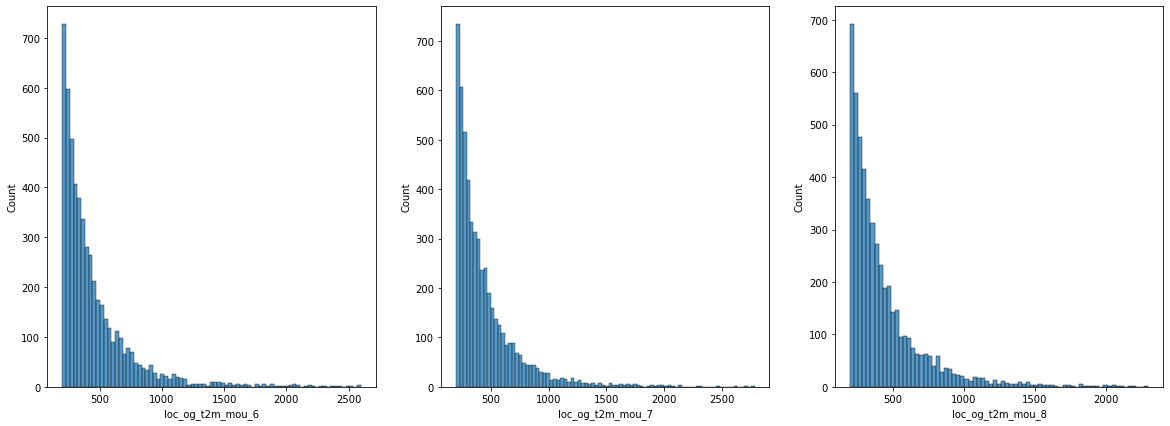

In [38]:
# loc_og_t2m_mou greater than 200, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2m_mou_6']>=200.0]['loc_og_t2m_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2m_mou_7']>=200.0]['loc_og_t2m_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2m_mou_8']>=200.0]['loc_og_t2m_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['loc_og_t2m_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['loc_og_t2m_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['loc_og_t2m_mou_8'].sum()))

- For month 6 and 7 the total number of min is almost same, and we could see a reduction of 2L min for month 8

Total Sum for 6 = 126745.93000000001
Total Sum for 7 = 128088.53
Total Sum for 8 = 117698.68000000001


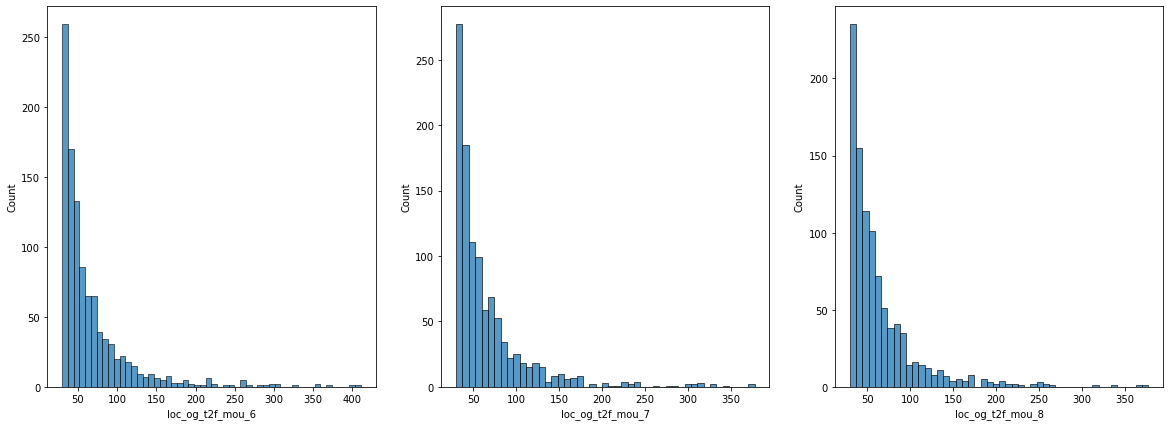

In [39]:
# loc_og_t2f_mou greater than 30, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2f_mou_6']>=30.0]['loc_og_t2f_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2f_mou_7']>=30.0]['loc_og_t2f_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2f_mou_8']>=30.0]['loc_og_t2f_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['loc_og_t2f_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['loc_og_t2f_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['loc_og_t2f_mou_8'].sum()))

- Here we can see a slight increase from month 6 to 7 and a dip towards month 8

Total Sum for 6 = 31842.120000000003
Total Sum for 7 = 36357.39
Total Sum for 8 = 33917.99


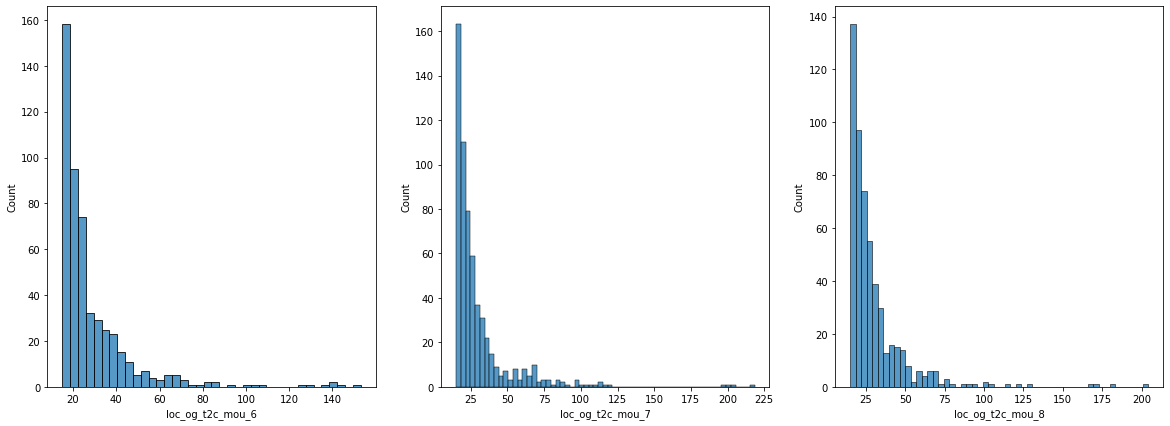

In [40]:
# loc_og_t2c_mou greater than 15, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2c_mou_6']>=15.0]['loc_og_t2c_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2c_mou_7']>=15.0]['loc_og_t2c_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_t2c_mou_8']>=15.0]['loc_og_t2c_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['loc_og_t2c_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['loc_og_t2c_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['loc_og_t2c_mou_8'].sum()))

- We could see an increase from month 6 to 7 and a decrese in month 8

Total Sum for 6 = 5174863.96
Total Sum for 7 = 5164621.09
Total Sum for 8 = 4785035.5


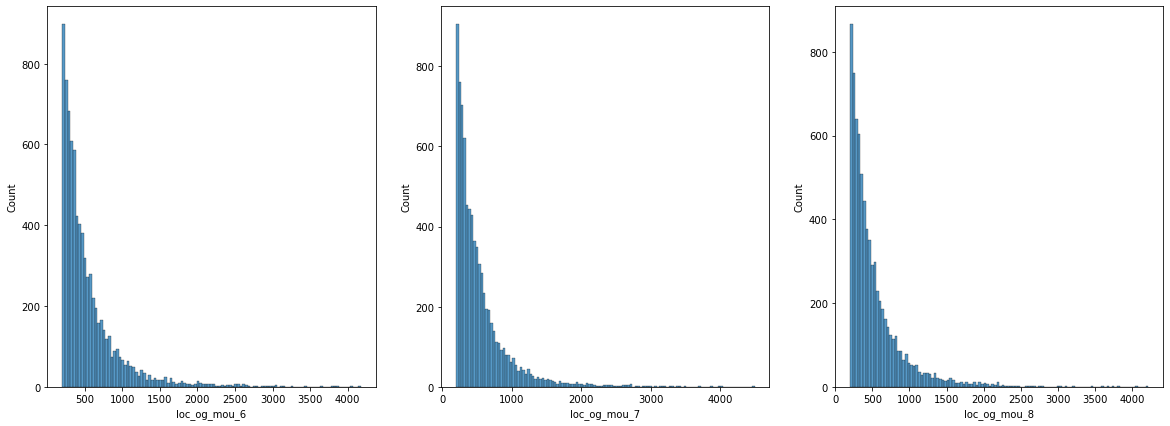

In [41]:
# loc_og_mou greater than 200, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_mou_6']>=200.0]['loc_og_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_mou_7']>=200.0]['loc_og_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['loc_og_mou_8']>=200.0]['loc_og_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['loc_og_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['loc_og_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['loc_og_mou_8'].sum()))

- We can see a reduction in total local outgoing minutes for month 8

Total Sum for 6 = 3434965.0100000002
Total Sum for 7 = 3574086.9399999995
Total Sum for 8 = 3040344.23


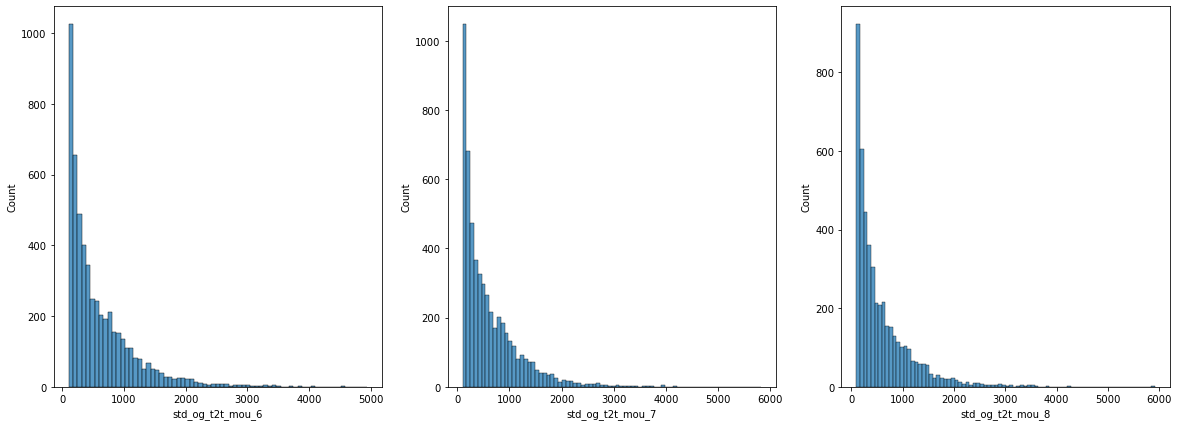

In [42]:
# std_og_t2t_mou greater than 100, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2t_mou_6']>=100.0]['std_og_t2t_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2t_mou_7']>=100.0]['std_og_t2t_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2t_mou_8']>=100.0]['std_og_t2t_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['std_og_t2t_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['std_og_t2t_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['std_og_t2t_mou_8'].sum()))

- We can see a decrease in month 8 compared to 6 and 7

Total Sum for 6 = 3750565.83
Total Sum for 7 = 3897610.24
Total Sum for 8 = 3249536.3099999996


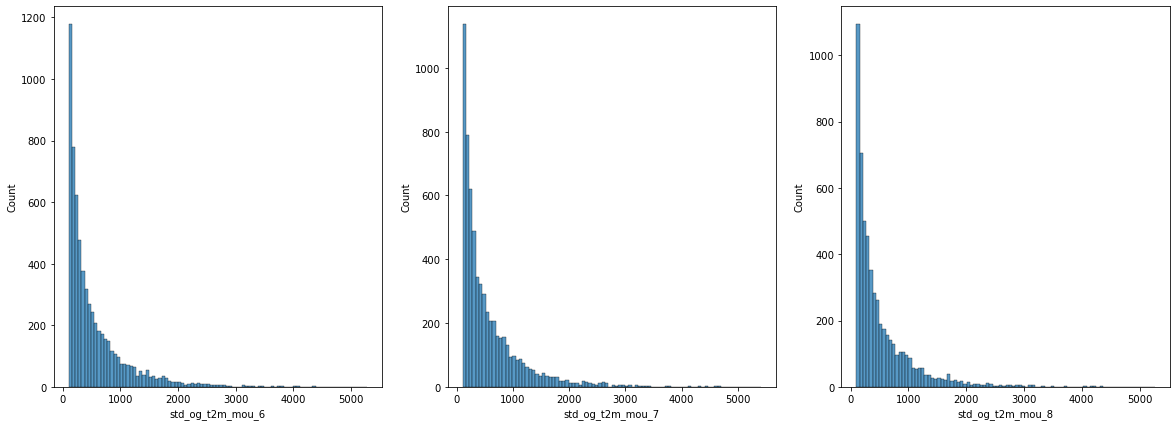

In [43]:
# std_og_t2m_mou greater than 100, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2m_mou_6']>=100.0]['std_og_t2m_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2m_mou_7']>=100.0]['std_og_t2m_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2m_mou_8']>=100.0]['std_og_t2m_mou_8'],ax=axs[2])
fig.show()


print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['std_og_t2m_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['std_og_t2m_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['std_og_t2m_mou_8'].sum()))

- We can see a decrease in month 8 compared to 6 and 7

Total Sum for 6 = 33593.55
Total Sum for 7 = 31716.3
Total Sum for 8 = 29514.699999999997


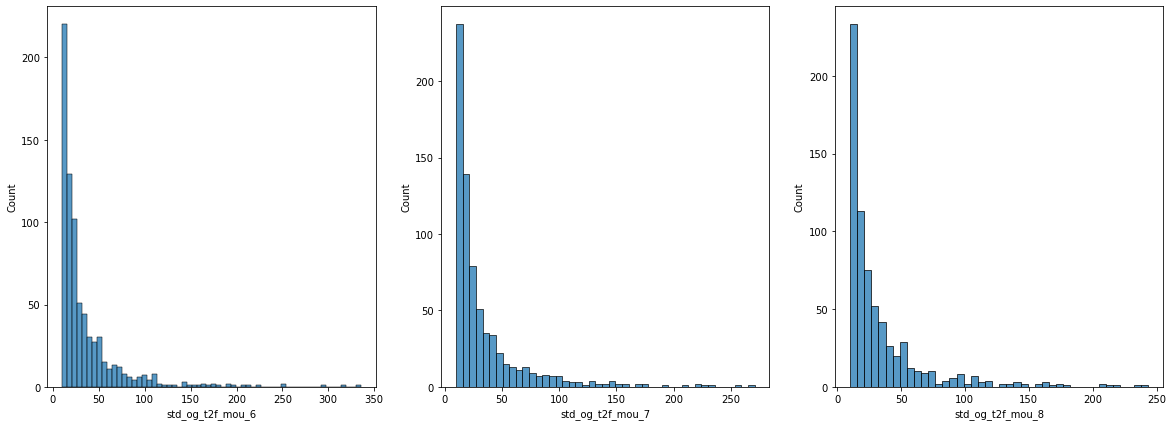

In [44]:
# std_og_t2f_mou greater than 10, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2f_mou_6']>=10.0]['std_og_t2f_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2f_mou_7']>=10.0]['std_og_t2f_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_t2f_mou_8']>=10.0]['std_og_t2f_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['std_og_t2f_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['std_og_t2f_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['std_og_t2f_mou_8'].sum()))

- We can see an reduction in the STD outgoing minutes t2f on months 7 and 8 compared to 6

Total Sum for 6 = 7222209.470000001
Total Sum for 7 = 7506412.33
Total Sum for 8 = 6325321.375


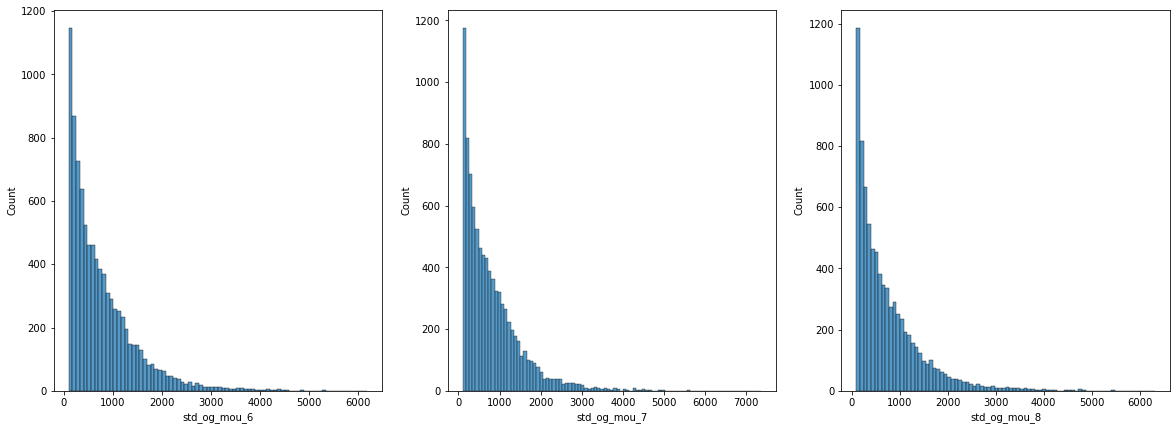

In [45]:
# std_og_mou greater than 100, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_mou_6']>=100.0]['std_og_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_mou_7']>=100.0]['std_og_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['std_og_mou_8']>=100.0]['std_og_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['std_og_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['std_og_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['std_og_mou_8'].sum()))

- We can observe an increase from 6 to 7 and a reduction from 7 to 8

Total Sum for 6 = 32501.04
Total Sum for 7 = 32595.89
Total Sum for 8 = 30599.160000000003


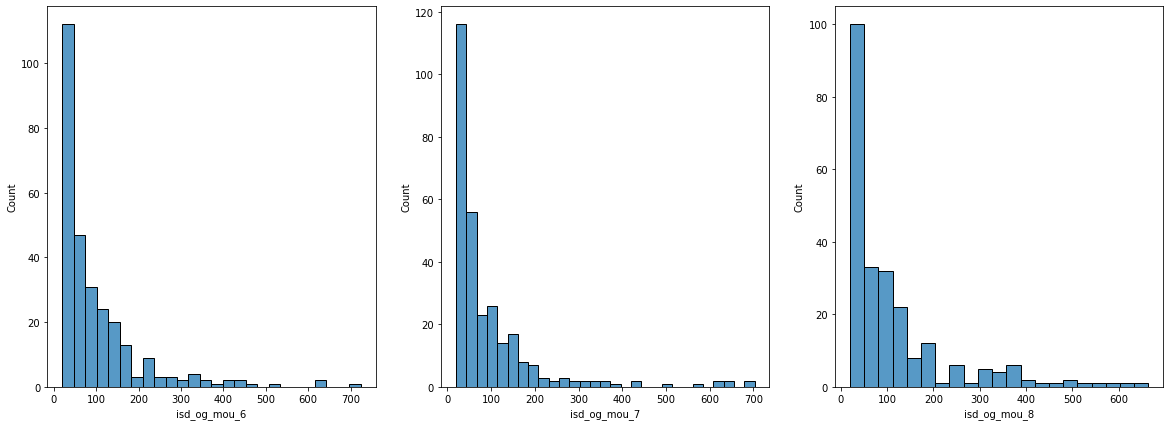

In [46]:
# isd_og_mou greater than 20, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['isd_og_mou_6']>=20.0]['isd_og_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['isd_og_mou_7']>=20.0]['isd_og_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['isd_og_mou_8']>=20.0]['isd_og_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['isd_og_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['isd_og_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['isd_og_mou_8'].sum()))

- No significant change in the minutes across month 6 and 7 but can observe some reduction in month 8

Total Sum for 6 = 117191.63
Total Sum for 7 = 139951.12
Total Sum for 8 = 132720.84


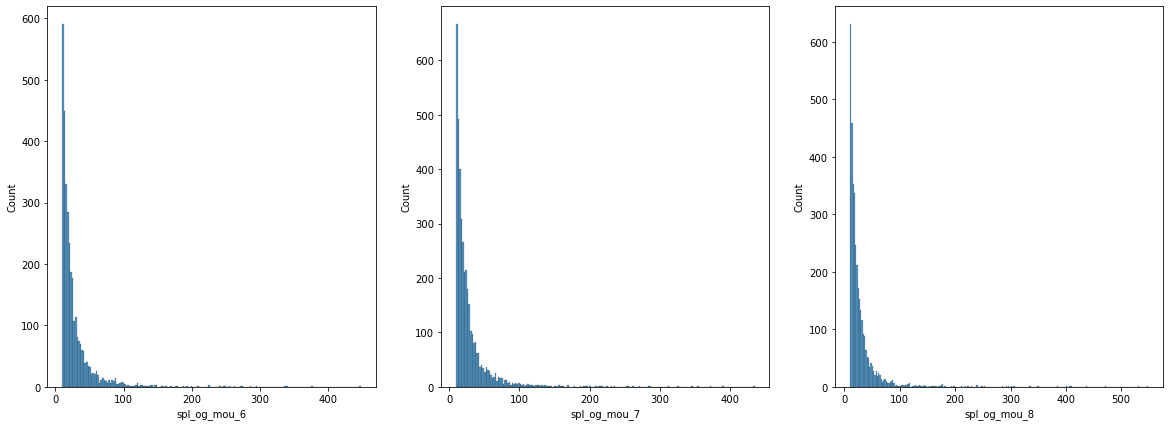

In [47]:
# spl_og_mou greater than 10, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['spl_og_mou_6']>=10.0]['spl_og_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['spl_og_mou_7']>=10.0]['spl_og_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['spl_og_mou_8']>=10.0]['spl_og_mou_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['spl_og_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['spl_og_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['spl_og_mou_8'].sum()))

- There is an increase in the number of minutes from 6 to 7 and a slight reduction in month 8

Total Sum for 6 = 12846.22
Total Sum for 7 = 205.39000000000001
Total Sum for 8 = 232.94


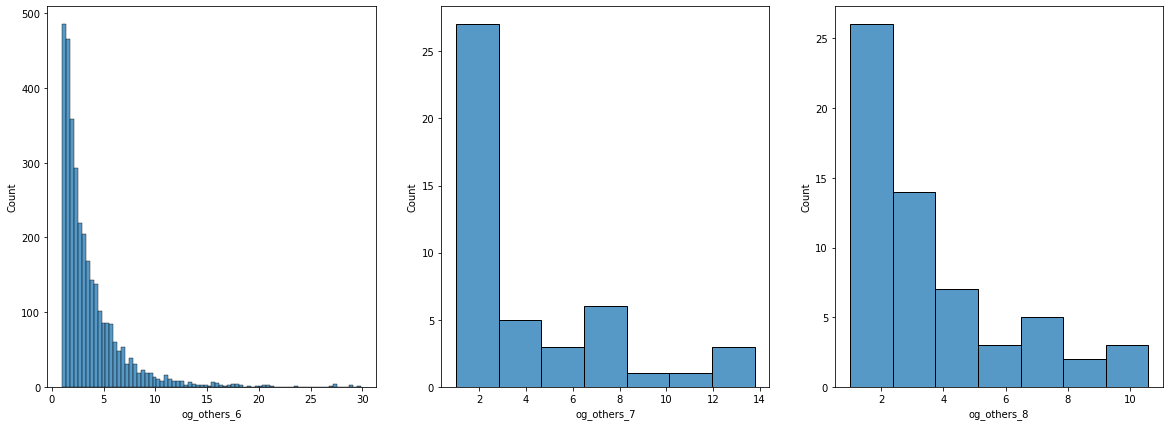

In [48]:
# og_others greater than 1, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['og_others_6']>=1.0]['og_others_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['og_others_7']>=1.0]['og_others_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['og_others_8']>=1.0]['og_others_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['og_others_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['og_others_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['og_others_8'].sum()))

- There is significant reduction in the minutes for months 7 and 8 compared to month 6

Total Sum for 6 = 12529953.68
Total Sum for 7 = 12815045.579999998
Total Sum for 8 = 11213883.52


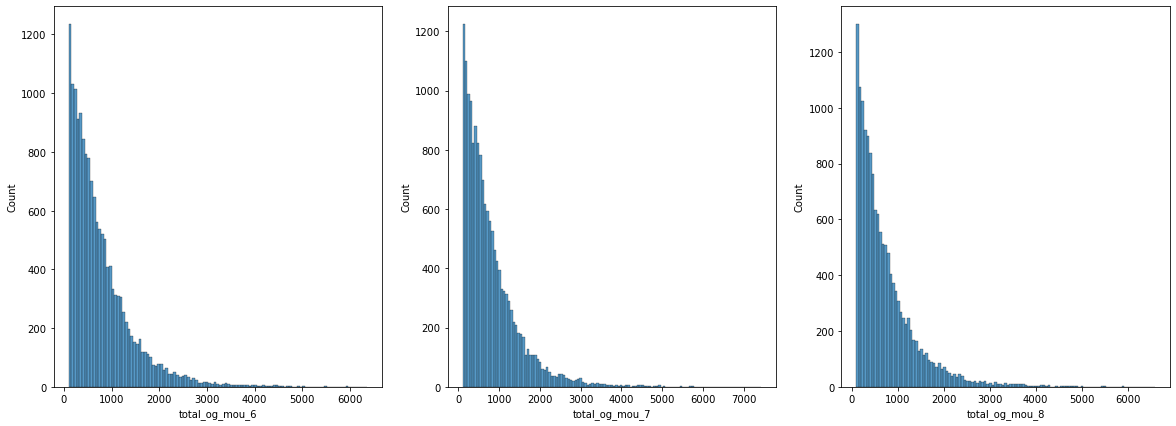

In [49]:
# total_og_mou greater than 100, as below that the values are same across the months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['total_og_mou_6']>=100.0]['total_og_mou_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['total_og_mou_7']>=100.0]['total_og_mou_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['total_og_mou_8']>=100.0]['total_og_mou_8'],ax=axs[2])
fig.show()


print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['total_og_mou_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['total_og_mou_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['total_og_mou_8'].sum()))

- From all the above observations related to outgoing minutes, most of them are showing an increase from month 6 to 7 and then a reduction towards month 8
- Hence in the total as well we can see an increase in month 7 and reduction in month 8

#### Incoming call minutes analysis

In [50]:
def comp_month_histplot(column_name, min_value):
	fig, axs = plt.subplots(1,3,figsize=(20,7))
	sns.histplot(Telecom_df_filtered[Telecom_df_filtered[column_name+'_6']>=min_value][column_name+'_6'],ax=axs[0])
	sns.histplot(Telecom_df_filtered[Telecom_df_filtered[column_name+'_7']>=min_value][column_name+'_7'],ax=axs[1])
	sns.histplot(Telecom_df_filtered[Telecom_df_filtered[column_name+'_8']>=min_value][column_name+'_8'],ax=axs[2])
	fig.show()

	print('Total Sum for 6 = {0}'.format(Telecom_df_filtered[column_name+'_6'].sum()))
	print('Total Sum for 7 = {0}'.format(Telecom_df_filtered[column_name+'_7'].sum()))
	print('Total Sum for 8 = {0}'.format(Telecom_df_filtered[column_name+'_8'].sum()))

Total Sum for 6 = 324090.92
Total Sum for 7 = 255480.16999999998
Total Sum for 8 = 239416.71999999997


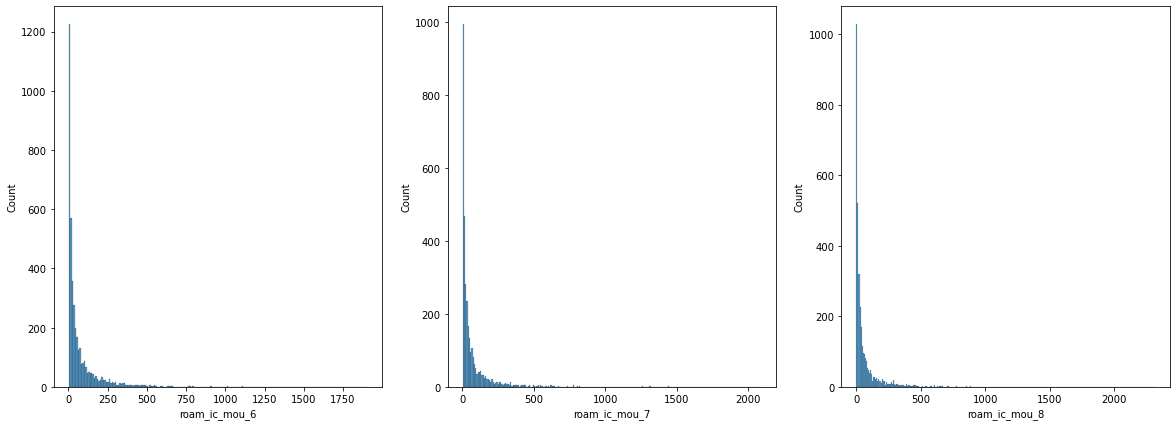

In [51]:
# roaming incoming minutes greater than 1 as below that the values are same across the months

comp_month_histplot('roam_ic_mou',1)

- We see major decrease in roaming incoming minutes from June to July and slight increase from July to August

Total Sum for 6 = 1349629.5299999998
Total Sum for 7 = 1363798.1
Total Sum for 8 = 1299459.33


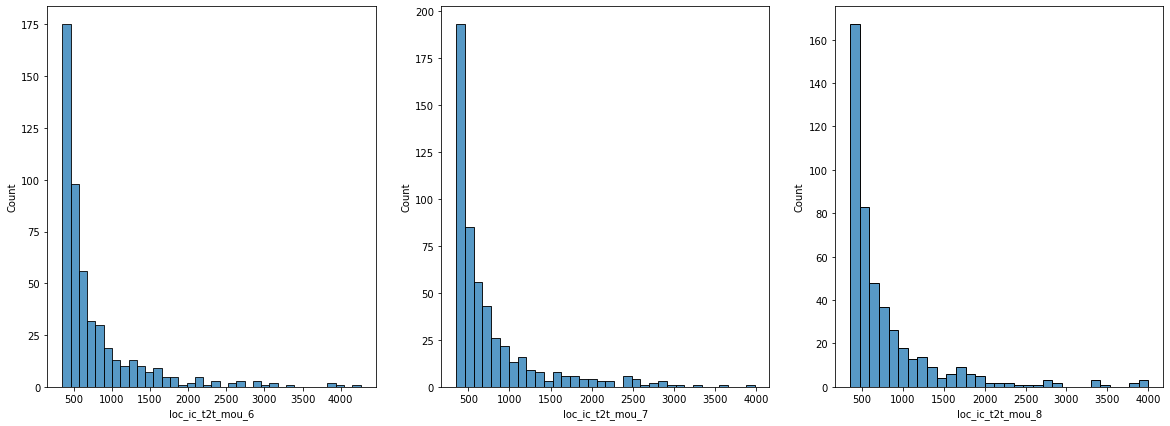

In [52]:
# loc_ic_t2t_mou greater than 350, as below that the values are same across the months

comp_month_histplot('loc_ic_t2t_mou',350)

- We see an increase in local incoming t2t from June to July and a decrease in August

Total Sum for 6 = 3109721.13
Total Sum for 7 = 3108290.71
Total Sum for 8 = 3035313.8400000003


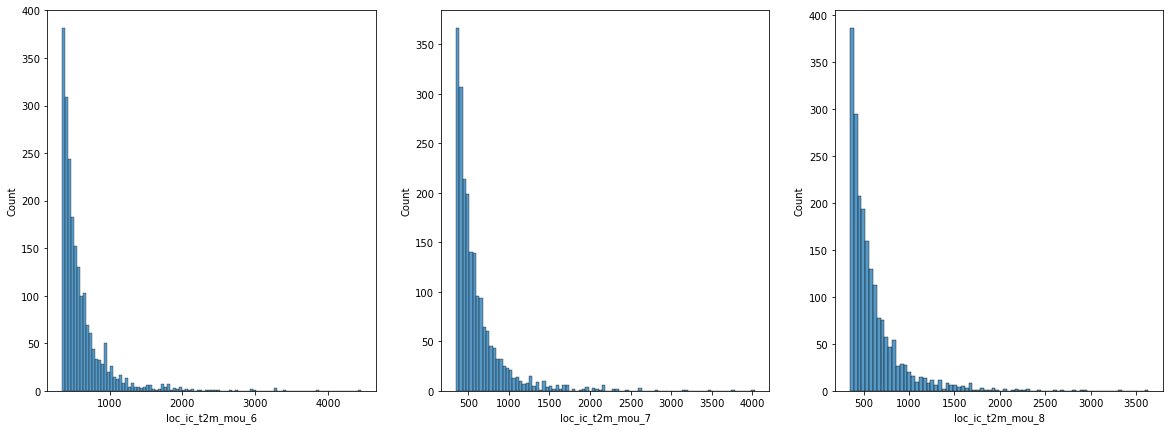

In [53]:
# loc_ic_t2m_mou greater than 200, as below that the values are same across the months

comp_month_histplot('loc_ic_t2m_mou',350)

- We see decreasing trend across months

Total Sum for 6 = 312867.08
Total Sum for 7 = 327527.32
Total Sum for 8 = 292982.58999999997


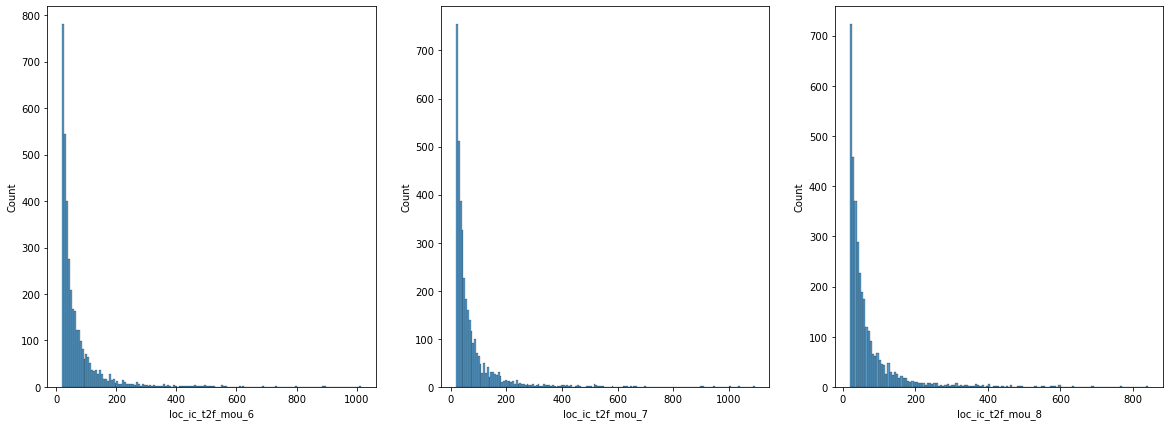

In [54]:
# loc_ic_t2f_mou greater than 30, as below that the values are same across the months

comp_month_histplot('loc_ic_t2f_mou',20)

- We see decreasing trend across months

Total Sum for 6 = 4779925.53
Total Sum for 7 = 4807108.71
Total Sum for 8 = 4643161.65


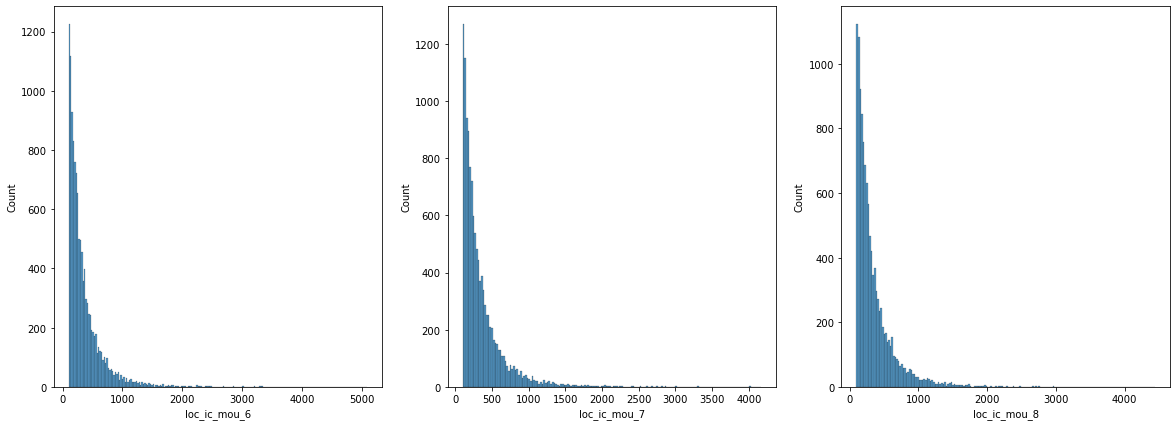

In [55]:
# loc_ic_mou greater than 200, as below that the values are same across the months

comp_month_histplot('loc_ic_mou',100)

- We see a slight increase in July from June and a slight decline in August

Total Sum for 6 = 286436.96
Total Sum for 7 = 295549.49
Total Sum for 8 = 273270.68


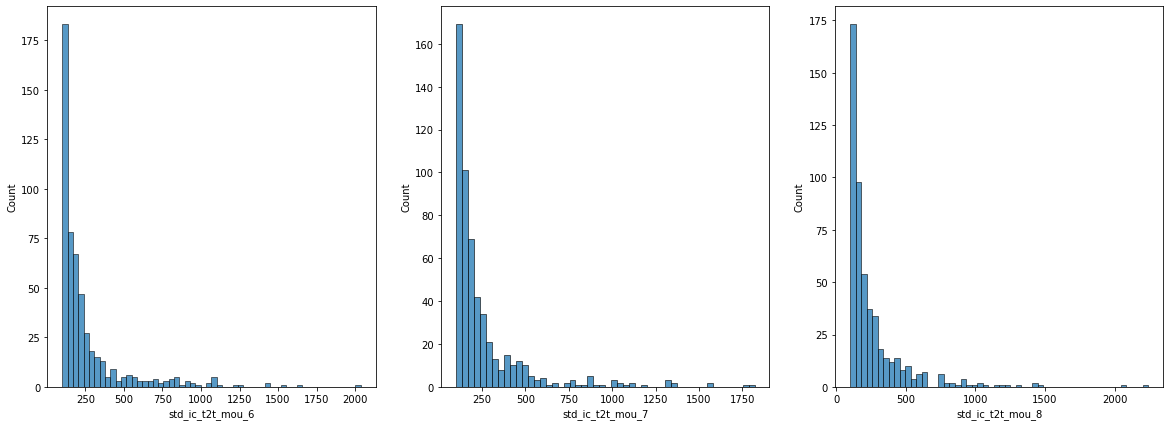

In [56]:
# std_ic_t2t_mou greater than 100, as below that the values are same across the months
comp_month_histplot('std_ic_t2t_mou',100)

- We see a decrease from June to July and increase from July to August

Total Sum for 6 = 595664.61
Total Sum for 7 = 629501.5700000001
Total Sum for 8 = 564611.21


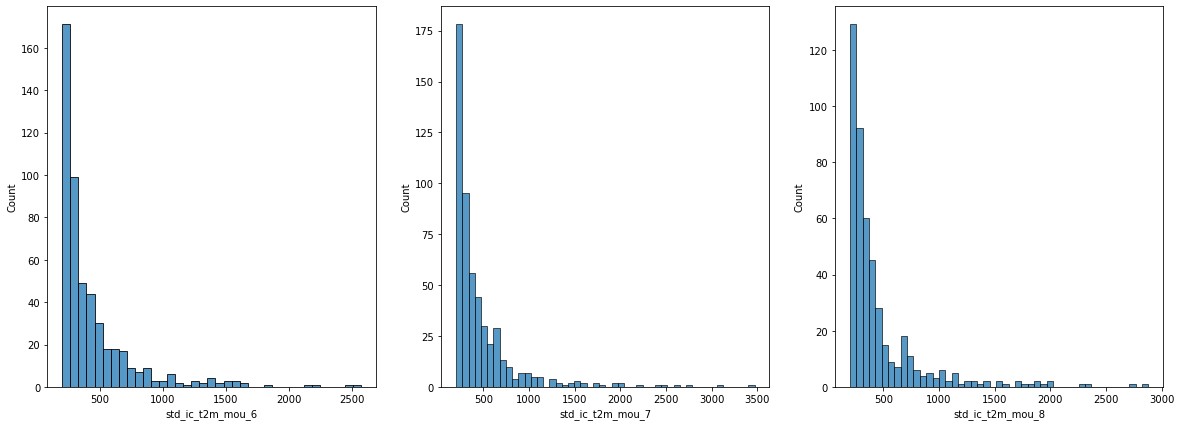

In [57]:
# std_ic_t2m_mou greater than 100, as below that the values are same across the months
comp_month_histplot('std_ic_t2m_mou',200)

- We see an increase from June to July but a drastic decrease from July to August 

Total Sum for 6 = 52647.399999999994
Total Sum for 7 = 53696.54
Total Sum for 8 = 47683.729999999996


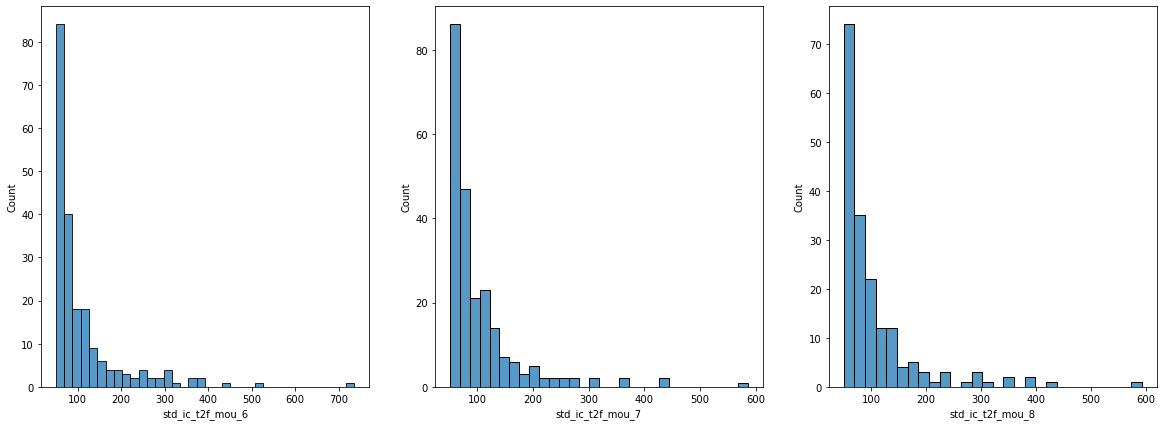

In [58]:
# std_ic_t2f_mou greater than 10, as below that the values are same across the months
comp_month_histplot('std_ic_t2f_mou',50)

- We see an increase from June to July but a drastic decrease from July to August 

Total Sum for 6 = 936324.49
Total Sum for 7 = 980339.7
Total Sum for 8 = 888724.77


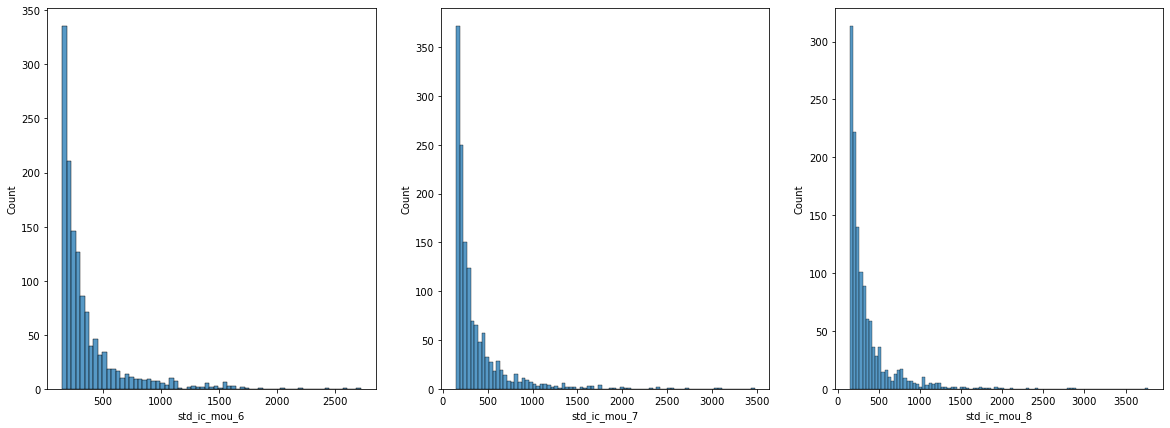

In [59]:
# std_ic_mou greater than 100, as below that the values are same across the months
comp_month_histplot('std_ic_mou',150)

- We see an increase from June to July but a decrease from July to August 

Total Sum for 6 = 206163.65
Total Sum for 7 = 229008.55
Total Sum for 8 = 220598.91999999998


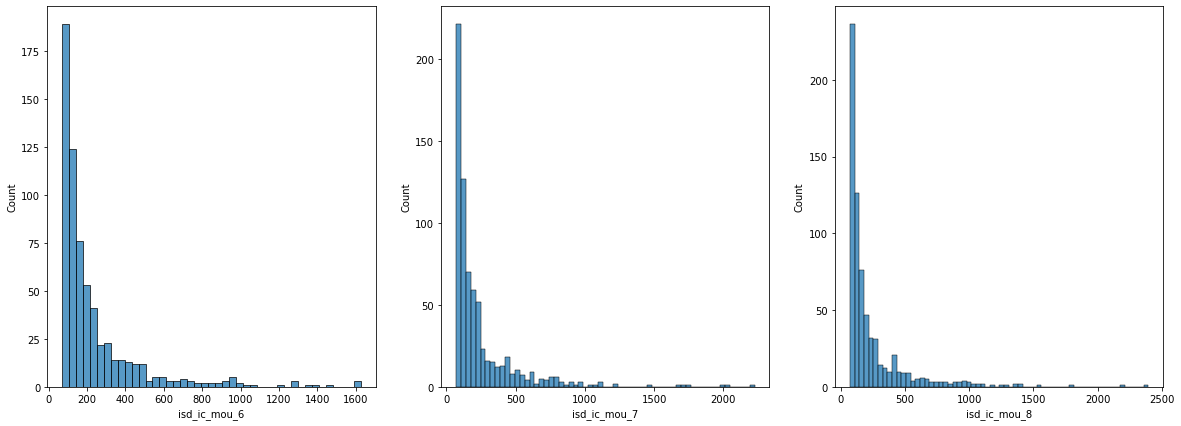

In [60]:
# isd_ic_mou greater than 20, as below that the values are same across the months
comp_month_histplot('isd_ic_mou',70)

- We see a slight increase from June to July and remains consistent for August

Total Sum for 6 = 1257.1499999999999
Total Sum for 7 = 366.67
Total Sum for 8 = 564.14


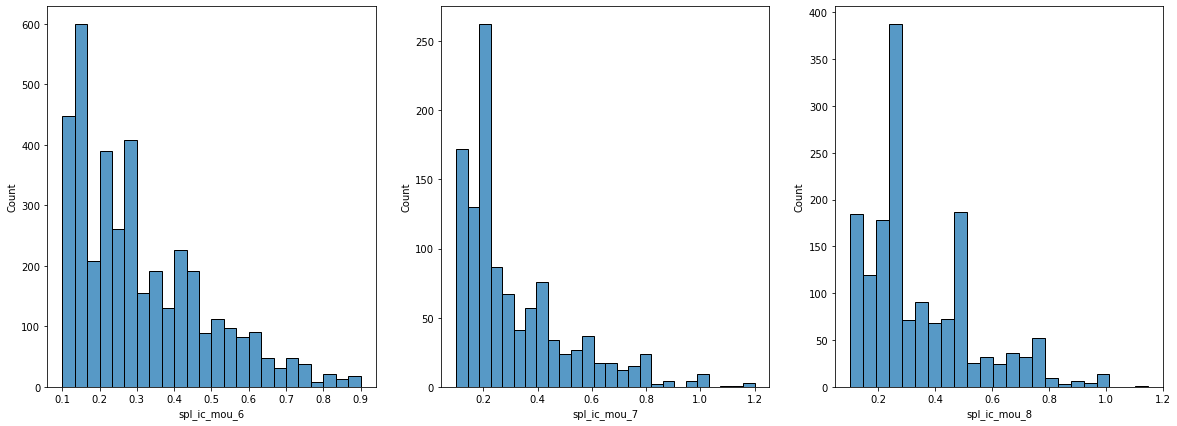

In [61]:
# spl_ic_mou greater than 0, as below that the values are same across the months
comp_month_histplot('spl_ic_mou',0.1)

- We see a drastic decrease from June to July and a slight increase in August

Total Sum for 6 = 21969.7
Total Sum for 7 = 27858.16
Total Sum for 8 = 23531.35


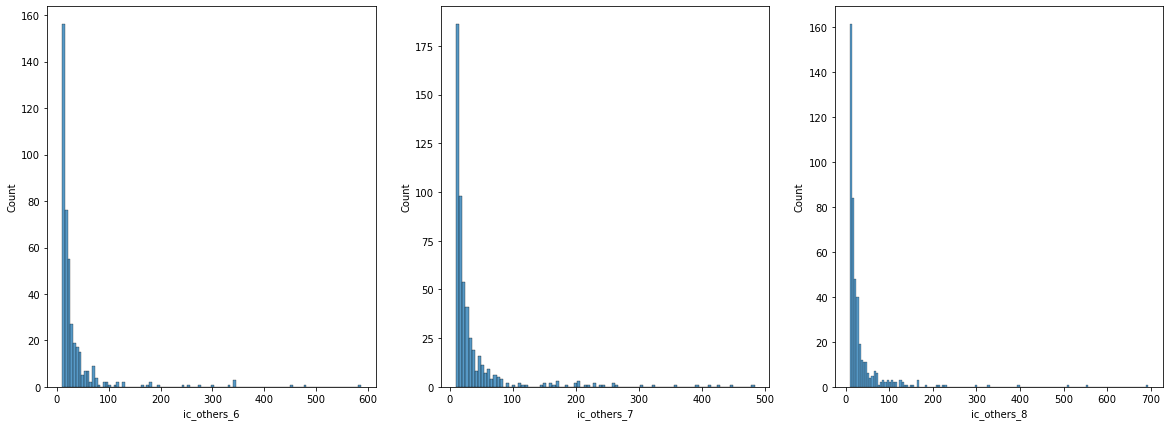

In [62]:
# ic_others greater than 1, as below that the values are same across the months
comp_month_histplot('ic_others',10)

- We see an increase from June to July but a decrease in August

Total Sum for 6 = 5907652.779999999
Total Sum for 7 = 6006722.539999999
Total Sum for 8 = 5695659.869999999


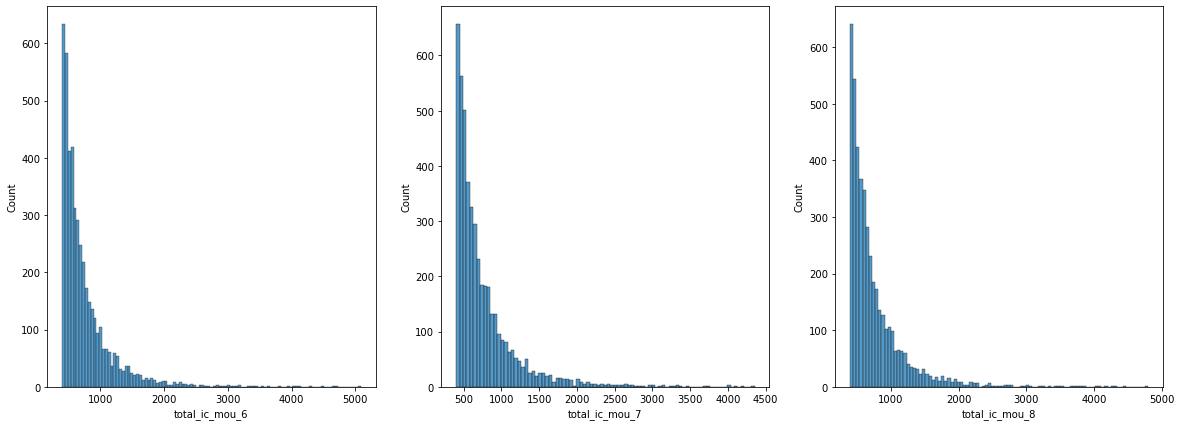

In [63]:
# total_ic_mou greater than 100, as below that the values are same across the months
comp_month_histplot('total_ic_mou',400)

- We see a slight increase from June to July and decrease in August

#### Date analysis

In [64]:
def date_formatting(date_value_counts):
    last_rech_date = pd.DataFrame()
    last_rech_date['Date'] = date_value_counts.index
    last_rech_date['Count'] = date_value_counts.values
    last_rech_date['Date'] = last_rech_date.apply(lambda x: x.Date.split('/')[1],axis=1)
    last_rech_date['Date'] = last_rech_date.apply(lambda x: int(x.Date),axis=1)
    last_rech_date.sort_values(by=['Date'], ascending=False)
    return last_rech_date

def date_analysis(column_name):
    mon_6_data = date_formatting(Telecom_df_filtered[column_name+'_6'].value_counts())
    sns.lineplot(data = mon_6_data, x='Date', y='Count', label="June")
    mon_7_data = date_formatting(Telecom_df_filtered[column_name+'_7'].value_counts())
    sns.lineplot(data = mon_7_data, x='Date', y='Count', label="July")
    mon_8_data = date_formatting(Telecom_df_filtered[column_name+'_8'].value_counts())
    sns.lineplot(data = mon_8_data, x='Date', y='Count', label="August")
    fig.show()

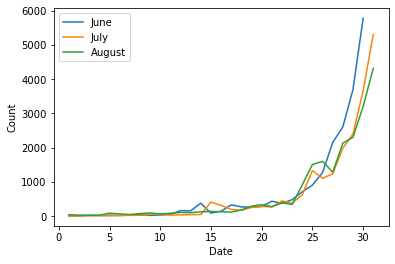

In [65]:
date_analysis('date_of_last_rech')

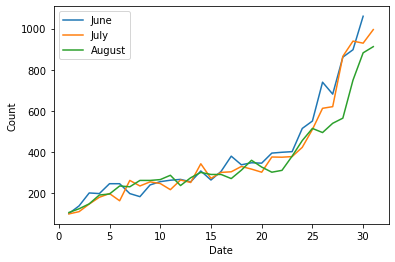

In [66]:
date_analysis('date_of_last_rech_data')

- We see decreasing trend in number of recharges happening
- Max number of recharges happen during the end of the month
- Sudden spike in normal recharges during end of month
- Relatively gradual increase in data recharges with max happening at the end of the month

#### Data related columns analysis

Total Sum for 6 = 25538.0
Total Sum for 7 = 28948.0
Total Sum for 8 = 24990.0


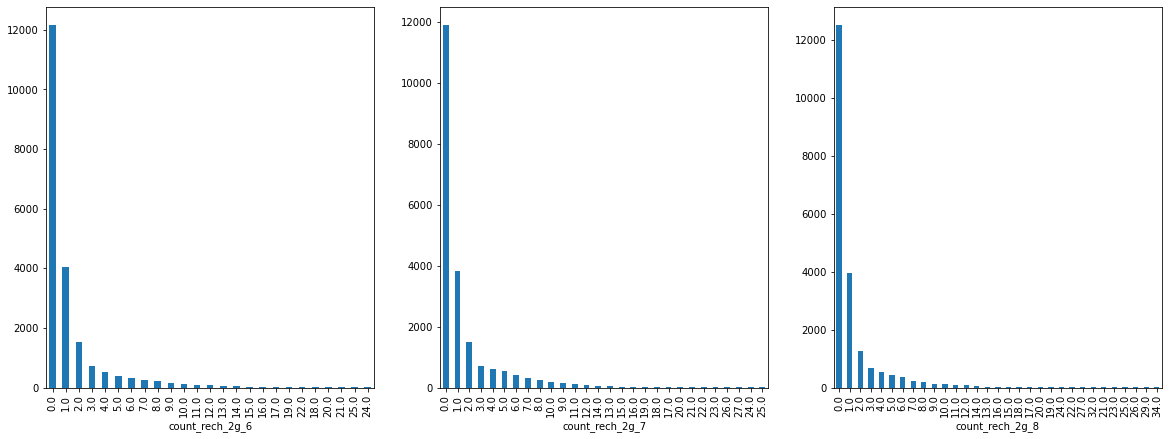

In [67]:
#count_rech_2g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(20,7))
Telecom_df_filtered.count_rech_2g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df_filtered.count_rech_2g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df_filtered.count_rech_2g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('count_rech_2g_6')
axs[1].set_xlabel('count_rech_2g_7')
axs[2].set_xlabel('count_rech_2g_8')
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['count_rech_2g_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['count_rech_2g_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['count_rech_2g_8'].sum()))

Total Sum for 6 = 8637.0
Total Sum for 7 = 9121.0
Total Sum for 8 = 8198.0


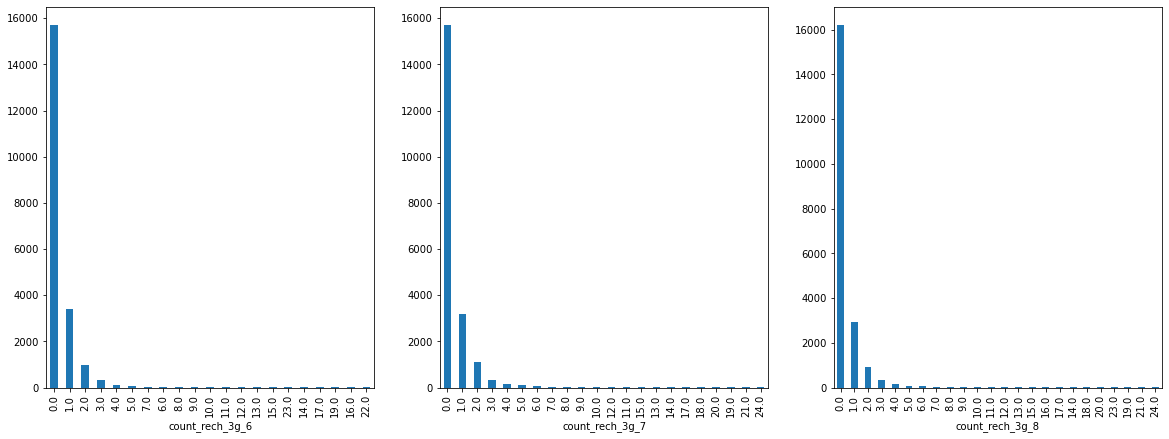

In [68]:
#count_rech_3g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(20,7))
Telecom_df_filtered.count_rech_3g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df_filtered.count_rech_3g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df_filtered.count_rech_3g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('count_rech_3g_6')
axs[1].set_xlabel('count_rech_3g_7')
axs[2].set_xlabel('count_rech_3g_8')
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['count_rech_3g_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['count_rech_3g_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['count_rech_3g_8'].sum()))

- Number of people using 2g seems to be more than 3g as per the above graphs
- Number of people using 2g or 3g across 3 months are almost similar

Total Sum for 6 = 34175.0
Total Sum for 7 = 38069.0
Total Sum for 8 = 33188.0


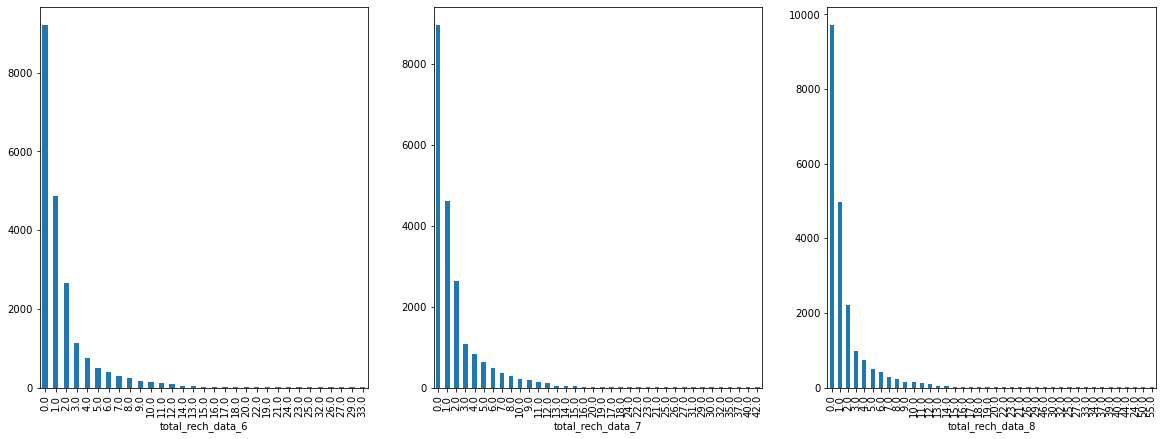

In [69]:
#total_rech_data across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(20,7))
Telecom_df_filtered.total_rech_data_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df_filtered.total_rech_data_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df_filtered.total_rech_data_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('total_rech_data_6')
axs[1].set_xlabel('total_rech_data_7')
axs[2].set_xlabel('total_rech_data_8')
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['total_rech_data_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['total_rech_data_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['total_rech_data_8'].sum()))

- Total reacharge data is increasing for month 7 and then decreased for month 8

Total Sum for 6 = 1595029.0
Total Sum for 7 = 1629379.0
Total Sum for 8 = 1478257.0


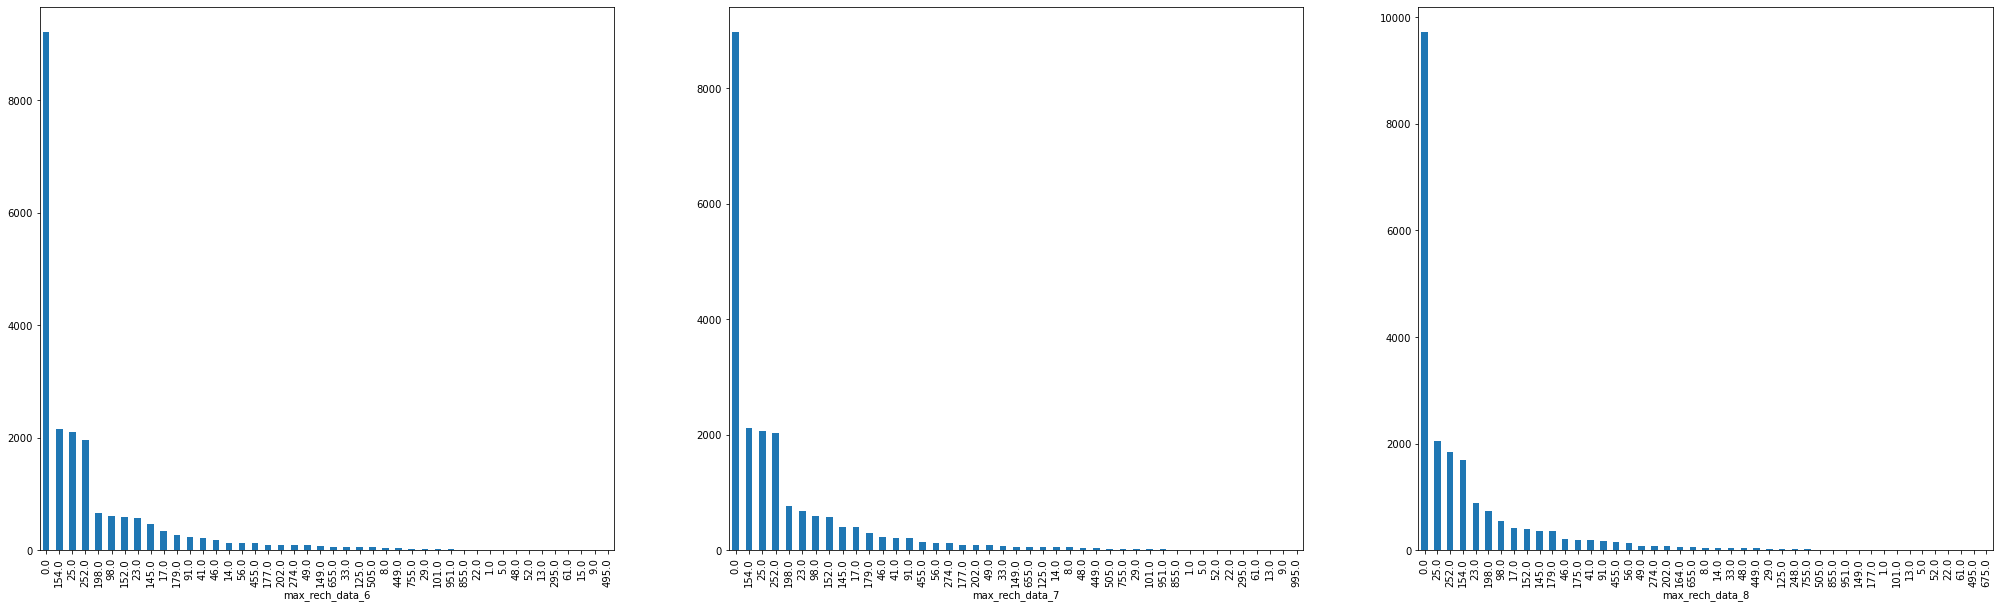

In [70]:
#max_rech_data across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df_filtered.max_rech_data_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df_filtered.max_rech_data_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df_filtered.max_rech_data_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('max_rech_data_6')
axs[1].set_xlabel('max_rech_data_7')
axs[2].set_xlabel('max_rech_data_8')
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['max_rech_data_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['max_rech_data_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['max_rech_data_8'].sum()))

- Number of users regarding for max amount 25,17,23 increased for month 7 and 8 compared to amount 154,198 ...
- Also we could see here as well an increase in month 7 and a reduction for month 8

Total Sum for 6 = 3631
Total Sum for 7 = 3852
Total Sum for 8 = 3205


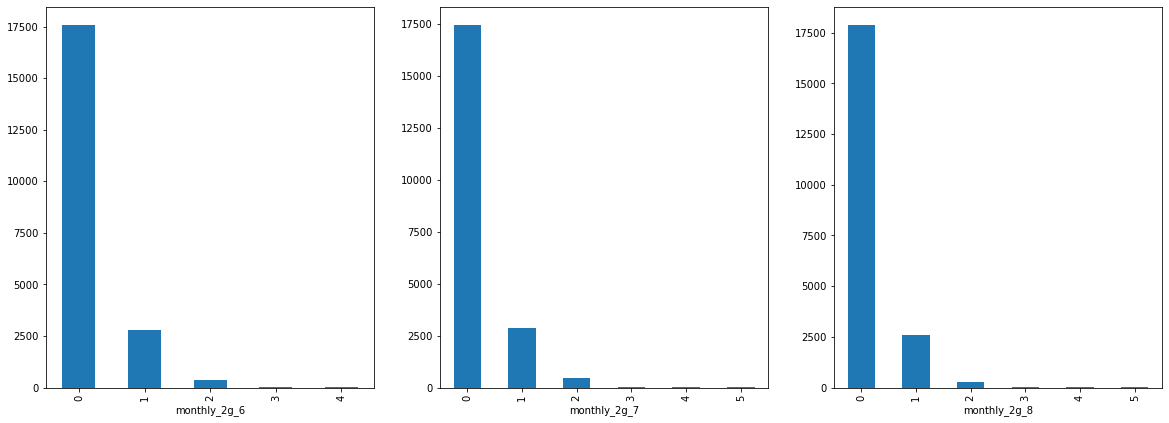

In [71]:
#monthly_2g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(20,7))
Telecom_df_filtered.monthly_2g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df_filtered.monthly_2g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df_filtered.monthly_2g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('monthly_2g_6')
axs[1].set_xlabel('monthly_2g_7')
axs[2].set_xlabel('monthly_2g_8')
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['monthly_2g_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['monthly_2g_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['monthly_2g_8'].sum()))

Total Sum for 6 = 4424
Total Sum for 7 = 4582
Total Sum for 8 = 4221


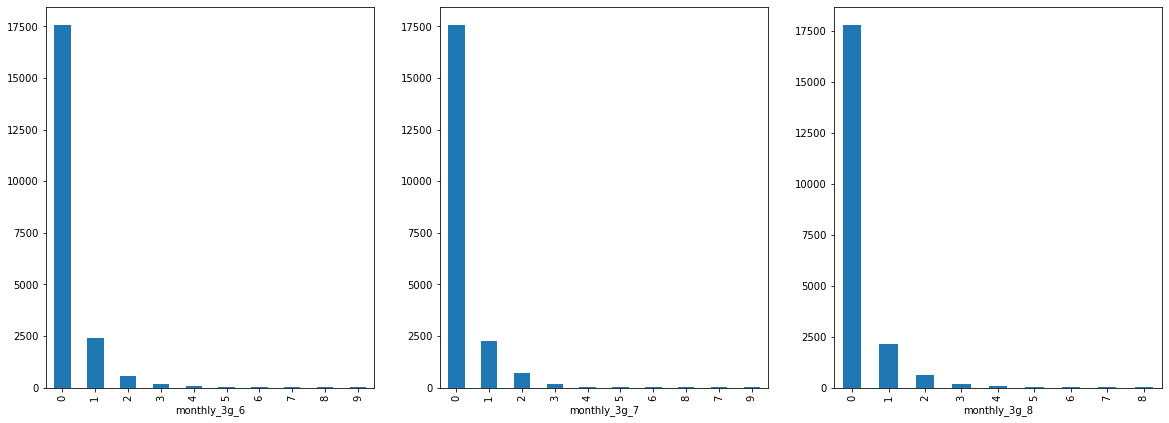

In [72]:
#monthly_3g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(20,7))
Telecom_df_filtered.monthly_3g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df_filtered.monthly_3g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df_filtered.monthly_3g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('monthly_3g_6')
axs[1].set_xlabel('monthly_3g_7')
axs[2].set_xlabel('monthly_3g_8')
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['monthly_3g_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['monthly_3g_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['monthly_3g_8'].sum()))

- Customers tend to use more monthly scheme in 3g than 2g

#### Amount related columns analysis

Total Sum for 6 = 11360398.331
Total Sum for 7 = 11350059.477
Total Sum for 8 = 10252642.901


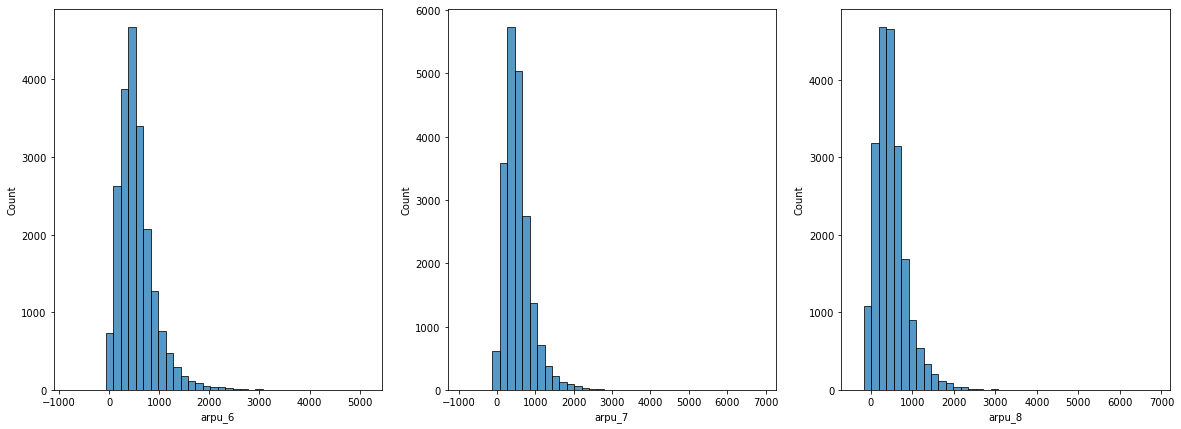

In [73]:
# average revenue per user across months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered['arpu_6'],bins=40, ax=axs[0])
sns.histplot(Telecom_df_filtered['arpu_7'],bins=40, ax=axs[1])
sns.histplot(Telecom_df_filtered['arpu_8'],bins=40, ax=axs[2])
fig.show()


print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['arpu_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['arpu_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['arpu_8'].sum()))

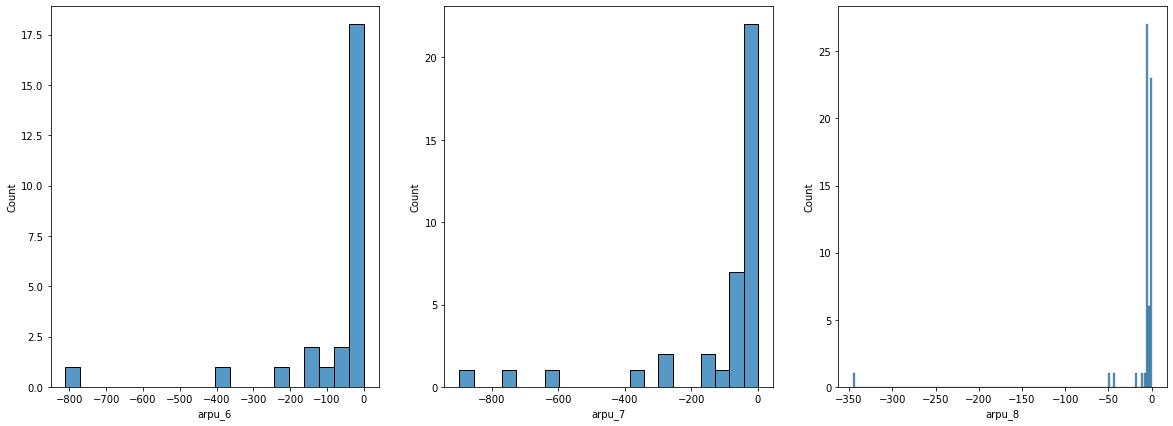

In [74]:
# -ve average revenue per user across months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_6']<0.0]['arpu_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_7']<0.0]['arpu_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_8']<0.0]['arpu_8'],ax=axs[2])
fig.show()


- The -ve average revenue per user keeps on decreasing over the months
- Also the total average revenue per user reduced for month 8 compared to 6 and 7

Total Sum for 6 = 1267743.63
Total Sum for 7 = 1274653.64
Total Sum for 8 = 1148845.39


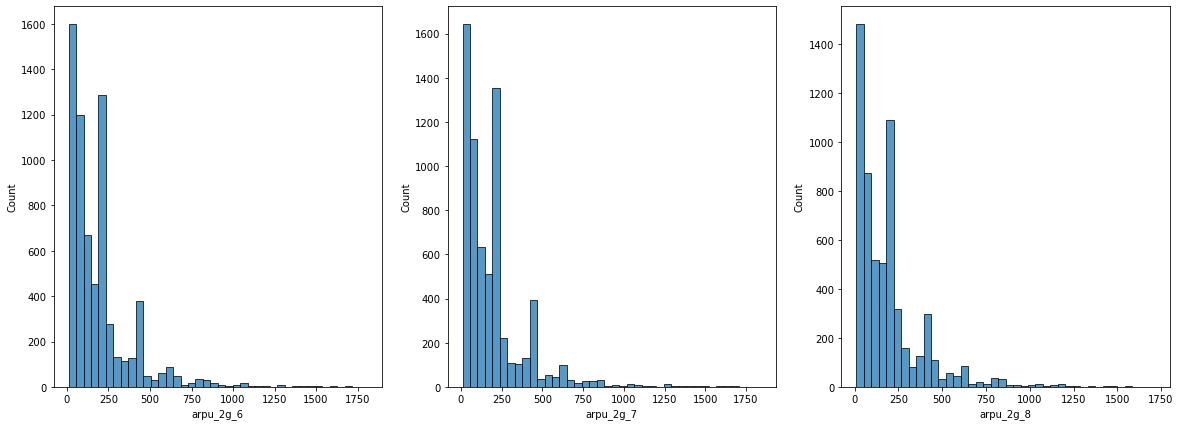

In [75]:
# average revenue 2g per user across months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_2g_6']>10.0]['arpu_2g_6'],bins=40, ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_2g_7']>10.0]['arpu_2g_7'],bins=40, ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_2g_8']>10.0]['arpu_2g_8'],bins=40, ax=axs[2])
fig.show()


print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['arpu_2g_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['arpu_2g_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['arpu_2g_8'].sum()))

Total Sum for 6 = 1333610.31
Total Sum for 7 = 1349682.24
Total Sum for 8 = 1231268.93


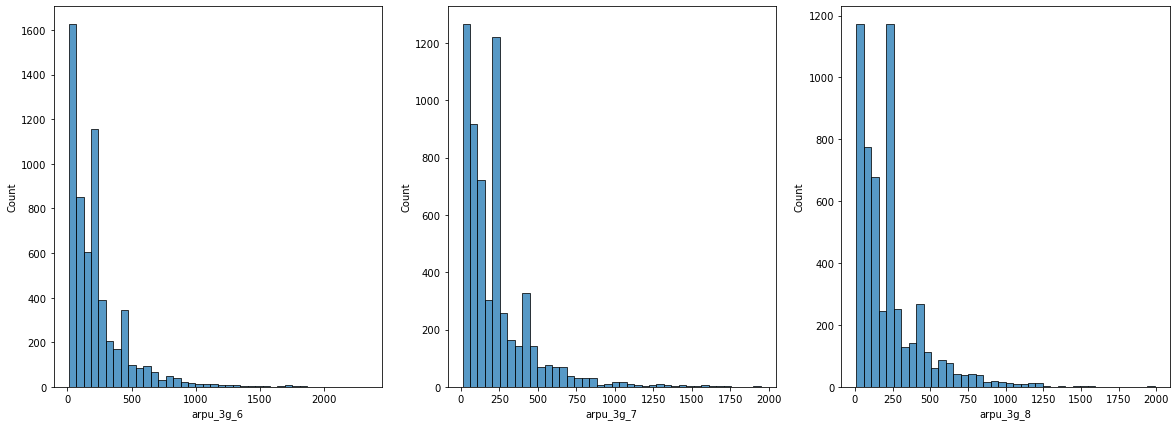

In [76]:
# average revenue 3g per user across months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_3g_6']>10.0]['arpu_3g_6'],bins=40, ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_3g_7']>10.0]['arpu_3g_7'],bins=40, ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['arpu_3g_8']>10.0]['arpu_3g_8'],bins=40, ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['arpu_3g_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['arpu_3g_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['arpu_3g_8'].sum()))

- Average revenue for 2g and 3g show an increase in month 7 and a dip in month 8
- Average revenue from 3g is more than 2g

Total Sum for 6 = 13436570
Total Sum for 7 = 13346834
Total Sum for 8 = 11780362


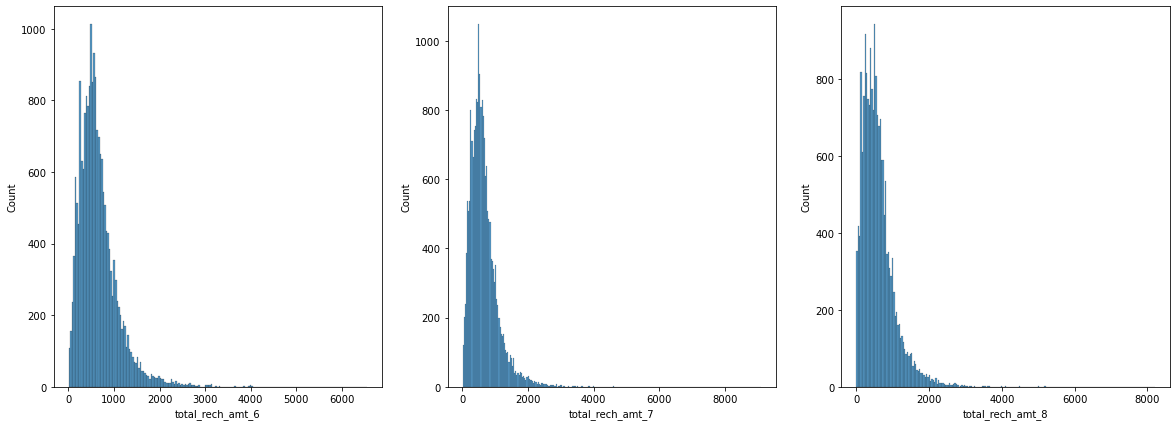

In [77]:
# total recharge amount across 3 months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['total_rech_amt_6']>0.0]['total_rech_amt_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['total_rech_amt_7']>0.0]['total_rech_amt_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered[Telecom_df_filtered['total_rech_amt_8']>0.0]['total_rech_amt_8'],ax=axs[2])
fig.show()

print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['total_rech_amt_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['total_rech_amt_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['total_rech_amt_8'].sum()))

- Total recharge amount has reduced significantly for month 8 compared to month 6 and 7

Max recharge amount for 6 2100
Max recharge amount for 7 2199
Max recharge amount for 8 2199
Percentage of customers with max recharge amount for 6 0.00028896166441918705
Percentage of customers with max recharge amount for 7 9.632055480639569e-05
Percentage of customers with max recharge amount for 8 0.00019264110961279138
   index  max_rech_amt_6
0    110        0.222356
1    154        0.078935
2    252        0.073830
   index  max_rech_amt_7
0    110        0.158158
1    154        0.078790
2    252        0.075612
   index  max_rech_amt_8
0    130        0.172173
1      0        0.073830
2    252        0.068869


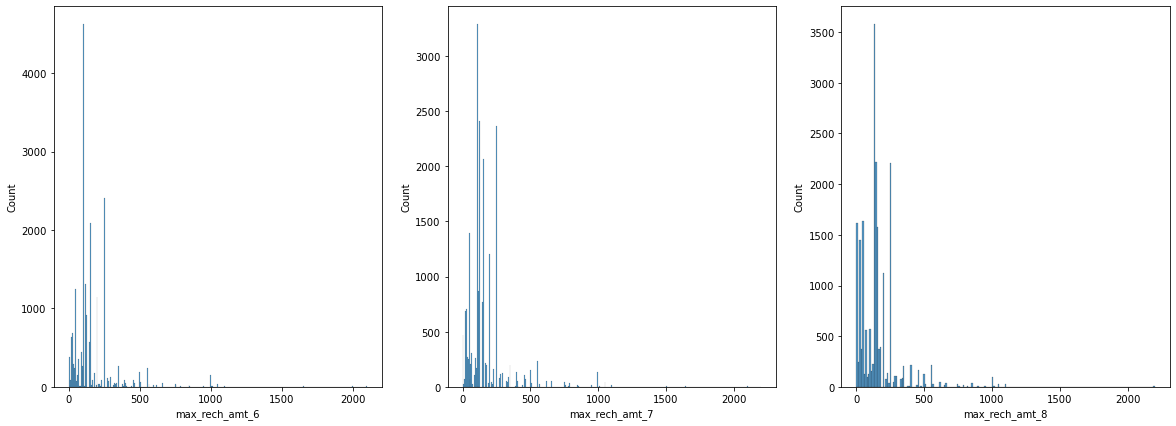

In [78]:
# max recharge amount across 3 months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered['max_rech_amt_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered['max_rech_amt_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered['max_rech_amt_8'],ax=axs[2])
fig.show()

print('Max recharge amount for 6 {0}'.format(Telecom_df_filtered['max_rech_amt_6'].max()))
print('Max recharge amount for 7 {0}'.format(Telecom_df_filtered['max_rech_amt_7'].max()))
print('Max recharge amount for 8 {0}'.format(Telecom_df_filtered['max_rech_amt_8'].max()))


print('Percentage of customers with max recharge amount for 6 {0}'.format(Telecom_df_filtered['max_rech_amt_6'].value_counts(normalize=True)[Telecom_df_filtered['max_rech_amt_6'].max()]))
print('Percentage of customers with max recharge amount for 7 {0}'.format(Telecom_df_filtered['max_rech_amt_7'].value_counts(normalize=True)[Telecom_df_filtered['max_rech_amt_7'].max()]))
print('Percentage of customers with max recharge amount for 8 {0}'.format(Telecom_df_filtered['max_rech_amt_8'].value_counts(normalize=True)[Telecom_df_filtered['max_rech_amt_8'].max()]))

# Top 3 max recharge amount

print(Telecom_df_filtered['max_rech_amt_6'].value_counts(normalize=True).to_frame().reset_index()[0:3])
print(Telecom_df_filtered['max_rech_amt_7'].value_counts(normalize=True).to_frame().reset_index()[0:3])
print(Telecom_df_filtered['max_rech_amt_8'].value_counts(normalize=True).to_frame().reset_index()[0:3])

- The no of customers recharging for the max amount 2100, 2199 are very less
- 15 to 22% customer recharge for max amount  110-130

Max last day recharge amount for 6 2100
Max last day recharge amount for 7 1100
Max last day recharge amount for 8 2100
   index  last_day_rch_amt_6
0    110            0.202514
1      0            0.143758
2     30            0.091216
   index  last_day_rch_amt_7
0      0            0.180168
1    110            0.090108
2     30            0.080765
   index  last_day_rch_amt_8
0      0            0.258091
1    130            0.161578
2     30            0.076093


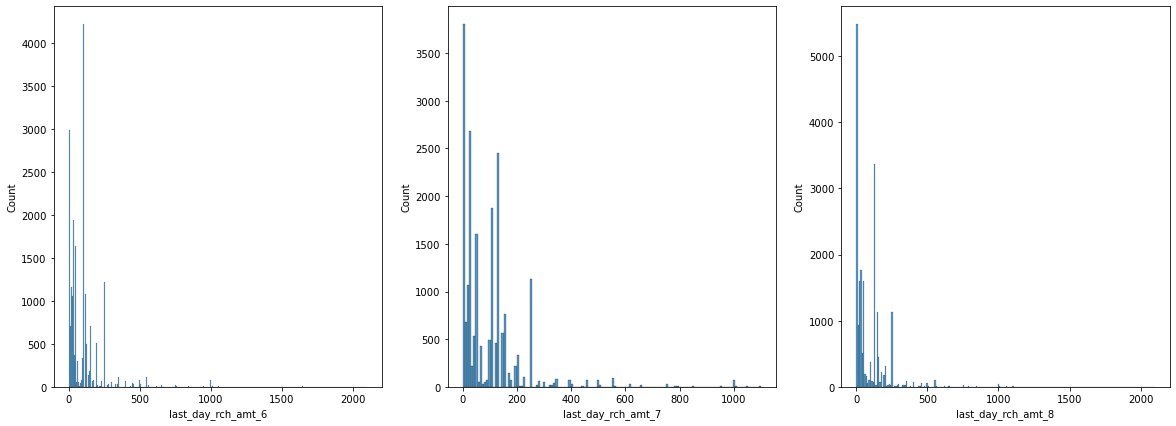

In [79]:
# last_day_rch_amt amount across months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered['last_day_rch_amt_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered['last_day_rch_amt_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered['last_day_rch_amt_8'],ax=axs[2])
fig.show()

print('Max last day recharge amount for 6 {0}'.format(Telecom_df_filtered['last_day_rch_amt_6'].max()))
print('Max last day recharge amount for 7 {0}'.format(Telecom_df_filtered['last_day_rch_amt_7'].max()))
print('Max last day recharge amount for 8 {0}'.format(Telecom_df_filtered['last_day_rch_amt_8'].max()))

# Top 3 last recharge amount

print(Telecom_df_filtered['last_day_rch_amt_6'].value_counts(normalize=True).to_frame().reset_index()[0:3])
print(Telecom_df_filtered['last_day_rch_amt_7'].value_counts(normalize=True).to_frame().reset_index()[0:3])
print(Telecom_df_filtered['last_day_rch_amt_8'].value_counts(normalize=True).to_frame().reset_index()[0:3])

- Last day recharge amount zero is increasing across month with 6% increase from 6 to 7
- On month 7 the last day recharge amount less compared to other months, which tells that on month 7 the last day recharge was less

#### Other columns

In [80]:
# funtion for grouped bar plot

def groupedBarPlot(varName):
    col1 = varName+'_6'
    col2 = varName+'_7'
    col3 = varName+'_8'
    
    df_6 = Telecom_df_filtered[col1].values.tolist()
    df_7 = Telecom_df_filtered[col2].values.tolist()
    df_8 = Telecom_df_filtered[col3].values.tolist()

    #First plot
    tr0 = go.Bar(
        x=Telecom_df_filtered[col1].value_counts().index.values,
        y=Telecom_df_filtered[col1].value_counts().values,
        name=col1
    )
    #Second plot
    tr1 = go.Bar(
        x=Telecom_df_filtered[col2].value_counts().index.values,
        y=Telecom_df_filtered[col2].value_counts().values,
        name=col2
    )
    #Third plot
    tr2 = go.Bar(
        x=Telecom_df_filtered[col3].value_counts().index.values,
        y=Telecom_df_filtered[col3].value_counts().values,
        name=col3
    )

    data = [tr0, tr1, tr2]

    layout = go.Layout(
        yaxis=dict(
            title='Count'
        ),
        xaxis=dict(
            title = varName + ' Variable'
        ),
        title = varName + ' variable distribution'
    )

    fig = go.Figure(data=data,layout = layout)

    py.iplot(fig, filename='grouped-bar')

In [81]:
groupedBarPlot('fb_user')

- Across months fb users are increasing by 100-300 users from month 6 to 7 and a dip in month 8

In [82]:
groupedBarPlot('night_pck_user')

- Number of users using night pack is very less
- On month 8 the users using night pack has decreased

Total Sum for 6 = 244201
Total Sum for 7 = 241093
Total Sum for 8 = 204989


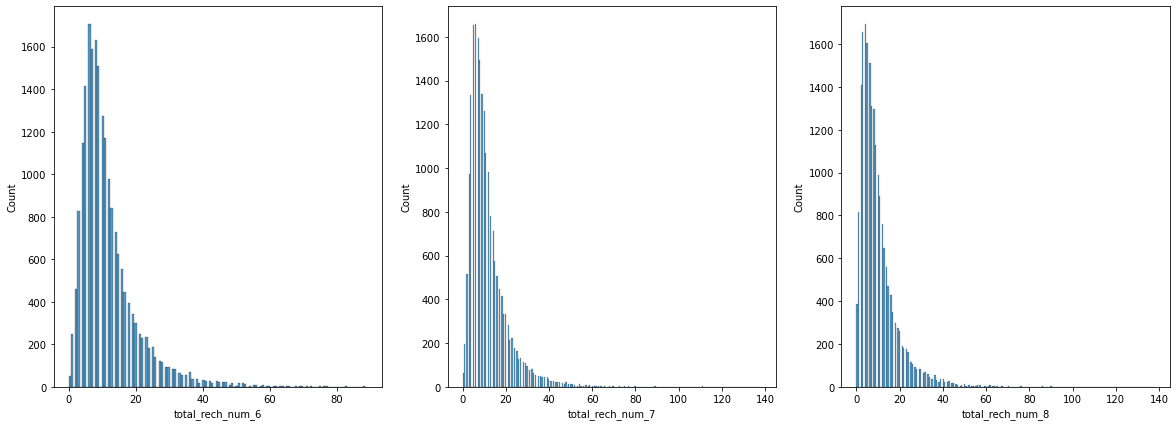

In [83]:
# total recharge number across 3 months

fig, axs = plt.subplots(1,3,figsize=(20,7))
sns.histplot(Telecom_df_filtered['total_rech_num_6'],ax=axs[0])
sns.histplot(Telecom_df_filtered['total_rech_num_7'],ax=axs[1])
sns.histplot(Telecom_df_filtered['total_rech_num_8'],ax=axs[2])
fig.show()


print('Total Sum for 6 = {0}'.format(Telecom_df_filtered['total_rech_num_6'].sum()))
print('Total Sum for 7 = {0}'.format(Telecom_df_filtered['total_rech_num_7'].sum()))
print('Total Sum for 8 = {0}'.format(Telecom_df_filtered['total_rech_num_8'].sum()))

- Total recharge number has been reduced for month 8

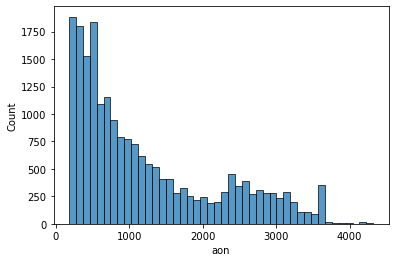

In [84]:
# aon

sns.histplot(Telecom_df_filtered['aon'])
fig.show()


### B. Deriving new features

#### From the above observations,for all features we see a dip in usage for month 8 compared to month 6 and 7, we can assume that customers who would churn might stop the usage on month 8. This means that a difference in the usage between month 8 and 6,7 for some key variables could give more insight

In [85]:
def derive_diff_cols(colname):
    newcol = colname+'_diff'
    col8 = colname+'_8'
    col6 = colname+'_6'
    col7 = colname+'_7'
    Telecom_df_filtered[newcol] =  Telecom_df_filtered[col8] - (( Telecom_df_filtered[col6] + Telecom_df_filtered[col7])/2)



colForDiff = ['arpu','onnet_mou','offnet_mou','roam_ic_mou', 'roam_og_mou', 'loc_og_mou','std_og_mou', 
 'isd_og_mou', 'spl_og_mou', 'total_og_mou', 'loc_ic_mou', 'std_ic_mou', 'isd_ic_mou', 
 'spl_ic_mou', 'total_ic_mou', 'total_rech_num', 'total_rech_amt', 'max_rech_amt' ,
 'total_rech_data', 'max_rech_data', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb' ]


for i in colForDiff:
    derive_diff_cols(i)

In [86]:
# checking shape to see the additional columns
Telecom_df_filtered.shape

(20764, 181)

### C. Multivariate Analysis

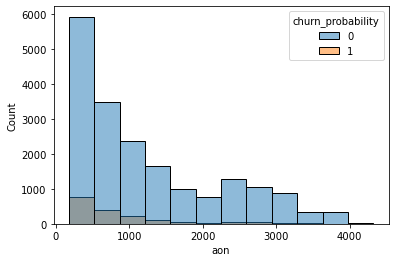

In [87]:
sns.histplot(data=Telecom_df_filtered,x='aon',hue='churn_probability',bins=12)
fig.show()

In [88]:
Telecom_df_filtered['tenure'] = (Telecom_df_filtered['aon']/30).round(0)

tn_range = [0, 6, 12, 24, 60, 61] 
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above'] 
Telecom_df_filtered['tenure_range'] = pd.cut(Telecom_df_filtered['tenure'], tn_range, labels=tn_label) 
Telecom_df_filtered['tenure_range'].head()

0    1-2 Yrs
1    1-2 Yrs
2    1-2 Yrs
3    2-5 Yrs
4    1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

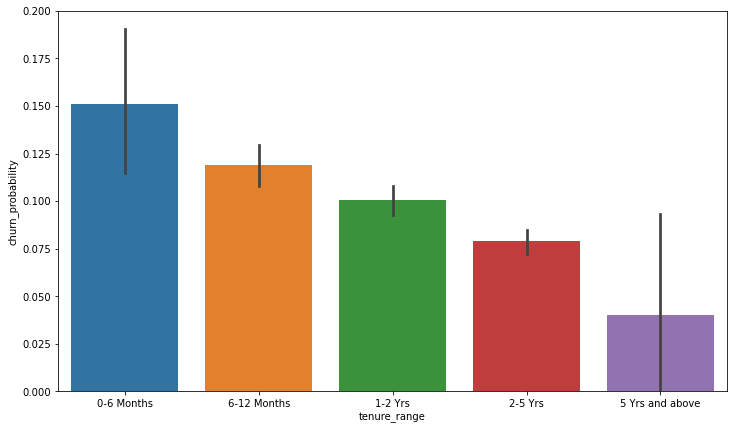

In [89]:
# Plotting a bar plot for tenure range 
plt.figure(figsize=[12,7])
sns.barplot(x='tenure_range',y='churn_probability', data=Telecom_df_filtered)
plt.show()

- Customers who are new to the operator tend to churn more than those who stayed for longer period

In [90]:
# setting churn probability the dependent variable as categorical for analysis

Telecom_df_filtered['churn_probability'] = Telecom_df_filtered['churn_probability'].astype("category")

					Distribution of total_rech_data_8 variable
 <=10_Recharges     10622
No_Recharge         9712
10-25_Recharges      410
>25_Recharges         20
Name: total_rech_data_group_8, dtype: int64


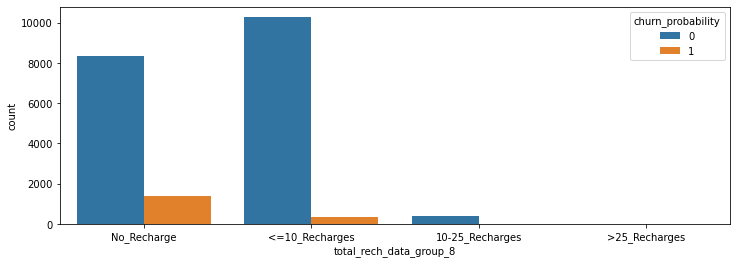

					Distribution of total_rech_num_8 variable
 <=10_Recharges     13410
10-25_Recharges     5775
>25_Recharges       1191
No_Recharge          388
Name: total_rech_num_group_8, dtype: int64


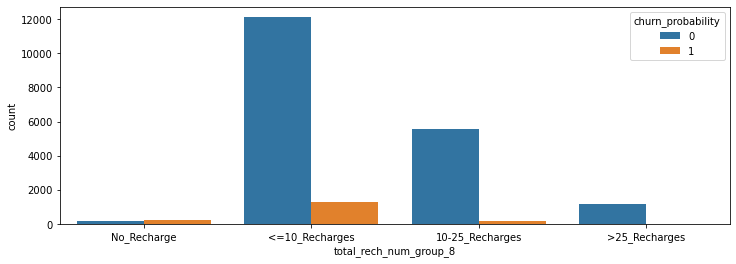

In [91]:
# Creating categories for month 8 column totalrecharge and their count
Telecom_df_filtered['total_rech_data_group_8']=pd.cut(Telecom_df_filtered['total_rech_data_8'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
Telecom_df_filtered['total_rech_num_group_8']=pd.cut(Telecom_df_filtered['total_rech_num_8'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])


# Plotting the results

plt.figure(figsize=[12,4])
sns.countplot(data=Telecom_df_filtered,x="total_rech_data_group_8",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_8 variable\n",Telecom_df_filtered['total_rech_data_group_8'].value_counts())
plt.show()
plt.figure(figsize=[12,4])
sns.countplot(data=Telecom_df_filtered,x="total_rech_num_group_8",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_num_8 variable\n",Telecom_df_filtered['total_rech_num_group_8'].value_counts())
plt.show()

- As the recharge amount increases the churn probablity also decreases.

### Box plot for each feature against churn probability

#### Outgoing minutes

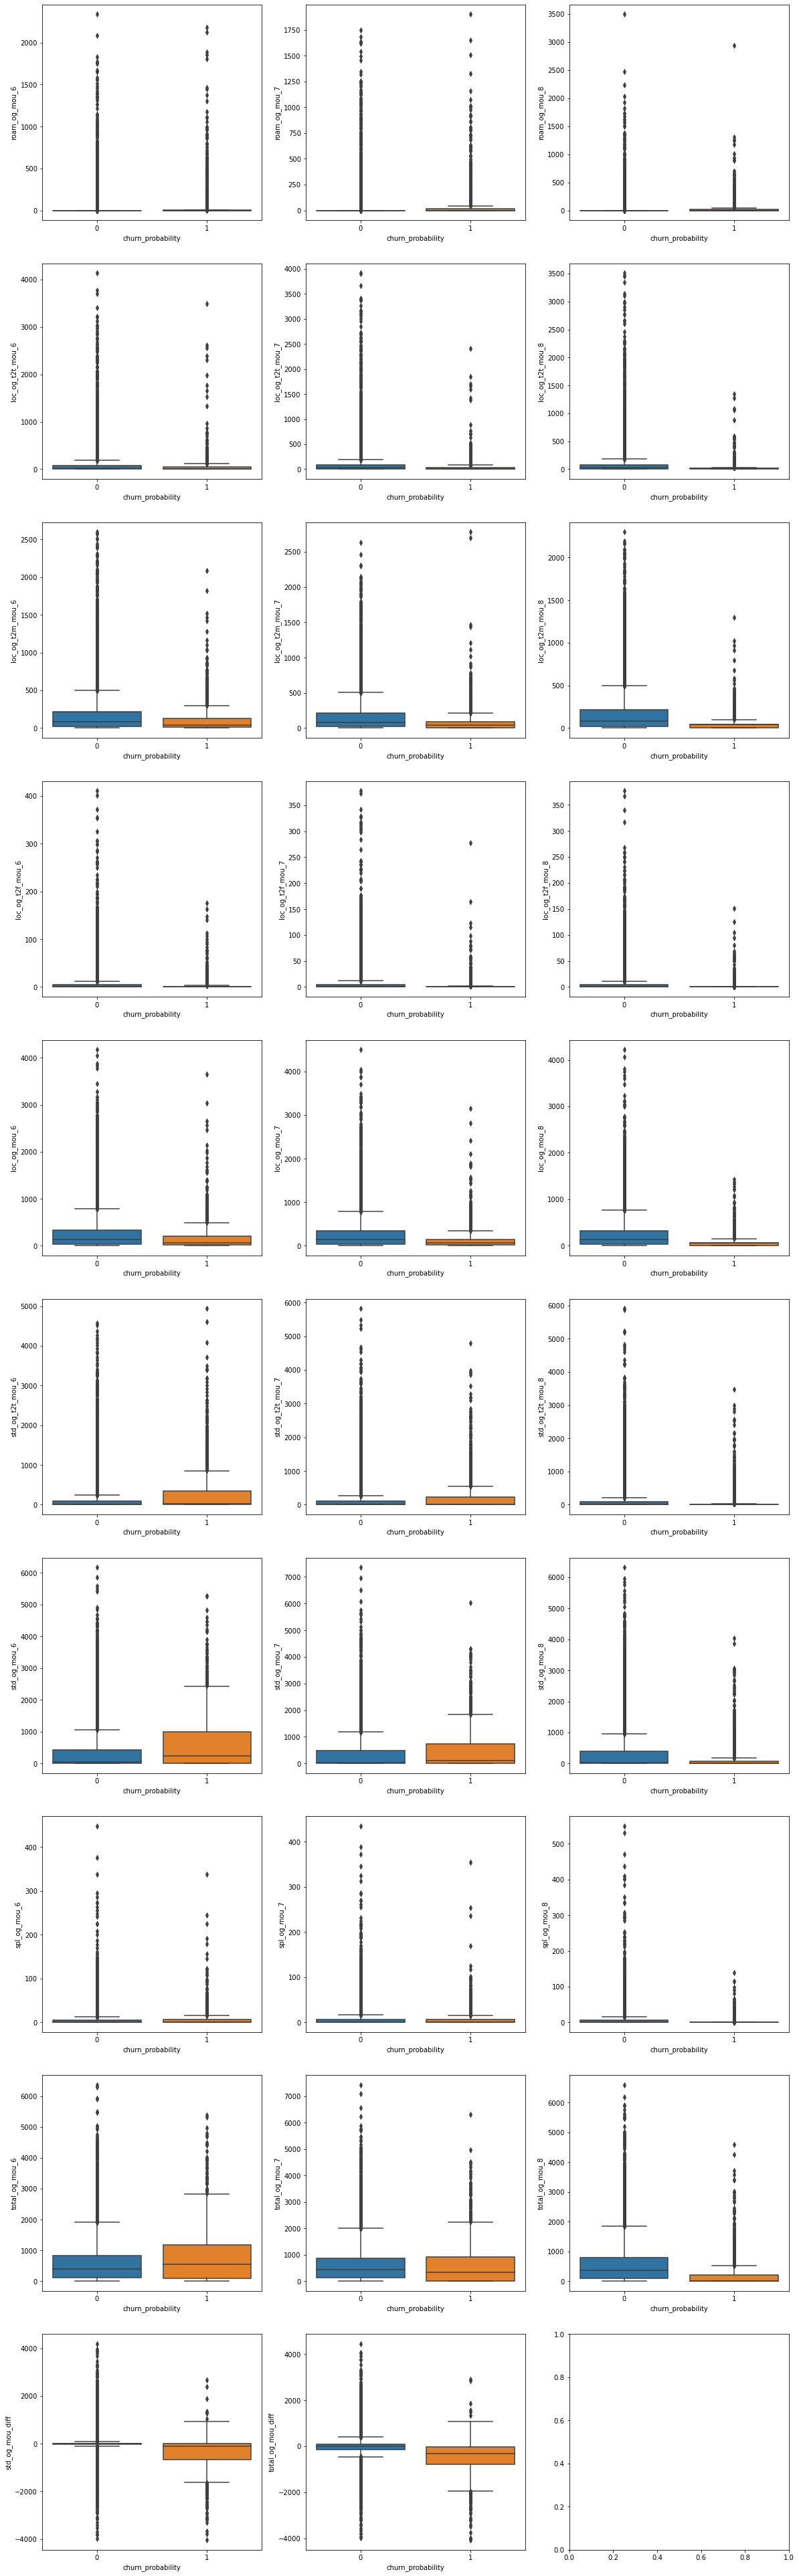

In [92]:
# For the following feature we can see some change when checked against churn probability

og_chart_cols = [ 'roam_og_mou_6','roam_og_mou_7','roam_og_mou_8',
                  'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8',
                  'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',
                  'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8',
                  'loc_og_mou_6','loc_og_mou_7','loc_og_mou_8',
                  'std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8',
                  'std_og_mou_6','std_og_mou_7','std_og_mou_8',
                  'spl_og_mou_6','spl_og_mou_7','spl_og_mou_8',
                  'total_og_mou_6','total_og_mou_7','total_og_mou_8',
                  'std_og_mou_diff','total_og_mou_diff'
                
                ]

fig, axs = plt.subplots(10,3,figsize=(20,70))
j=0
for i in og_chart_cols:
    if(j>=3):
        k=j%3
    else:
        k=j
    sns.boxplot(Telecom_df_filtered['churn_probability'],Telecom_df_filtered[i],ax=axs[j//3][k])
    j+=1
fig.show()

- Roaming outgoing minutes of usage is increased by some value for 75th to 100th percentile of churned customers for July and August month.



- Following variables are decreasing across the months for churned customers
  - Local outgoing mobile to mobile in same operator minutes.
  - Local outgoing mobile to mobile in other operator minutes.
  - Local ougoing operator to fixed lines of T minutes.
  - Total Local outgoing minutes of usage.
  
  

- Following variables strongly indicate customer has stopeed using in August month reason has highest usage of minutes in June and July and significantly reduced in August month. 
    - STD outgoing mobile to mobile in same operator minutes.
    - Special Outgoing minutes of usage.
    - Total Outgoing minutes of usage.
    - STD outgoing minutes of usage difference between Aug month and  Average of June and July month.
    - Total Outgoing minutes of usage difference between Aug month and  Average of June and July month.


#### Incoming minutes

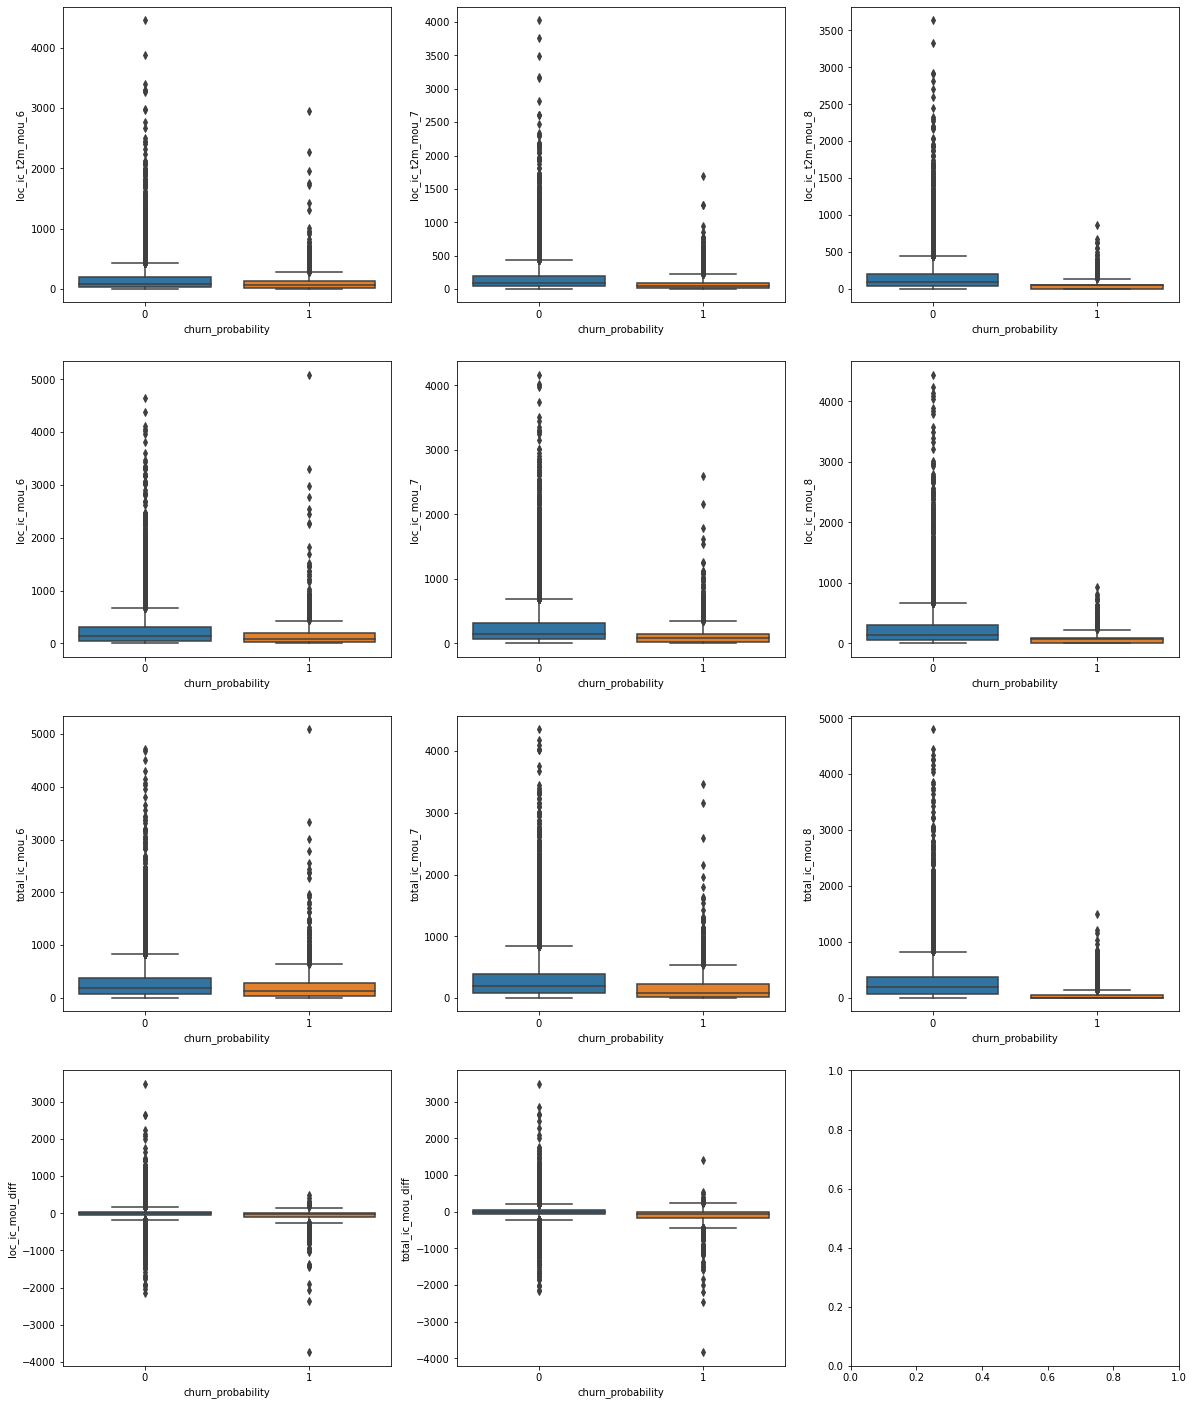

In [93]:
# For the following feature we can see some change when checked against churn probability

ic_chart_cols = [ 'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',
                  'loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8',
                  'total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                  'loc_ic_mou_diff','total_ic_mou_diff'
                
                ]

fig, axs = plt.subplots(4,3,figsize=(20,25))
j=0
for i in ic_chart_cols:
    if(j>=3):
        k=j%3
    else:
        k=j
    sns.boxplot(Telecom_df_filtered['churn_probability'],Telecom_df_filtered[i],ax=axs[j//3][k])
    j+=1
fig.show()

- Following variables are decreasing across the months for churned customers
  - Local Incoming mobile to mobile in same operator minutes.
  - Local Incoming minutes of usage.
  - Total Local Incoming minutes of usage.
    
    
- Following variables strongly indicate customer has stopeed using in August month reason has highest usage of minutes in June and July and significantly reduced in August month.
   - Local Incoming minutes of usage difference between Aug month and Average of June and July month.
   - Total Incoming minutes of usage difference between Aug month and Average of June and July month.    

#### Data features

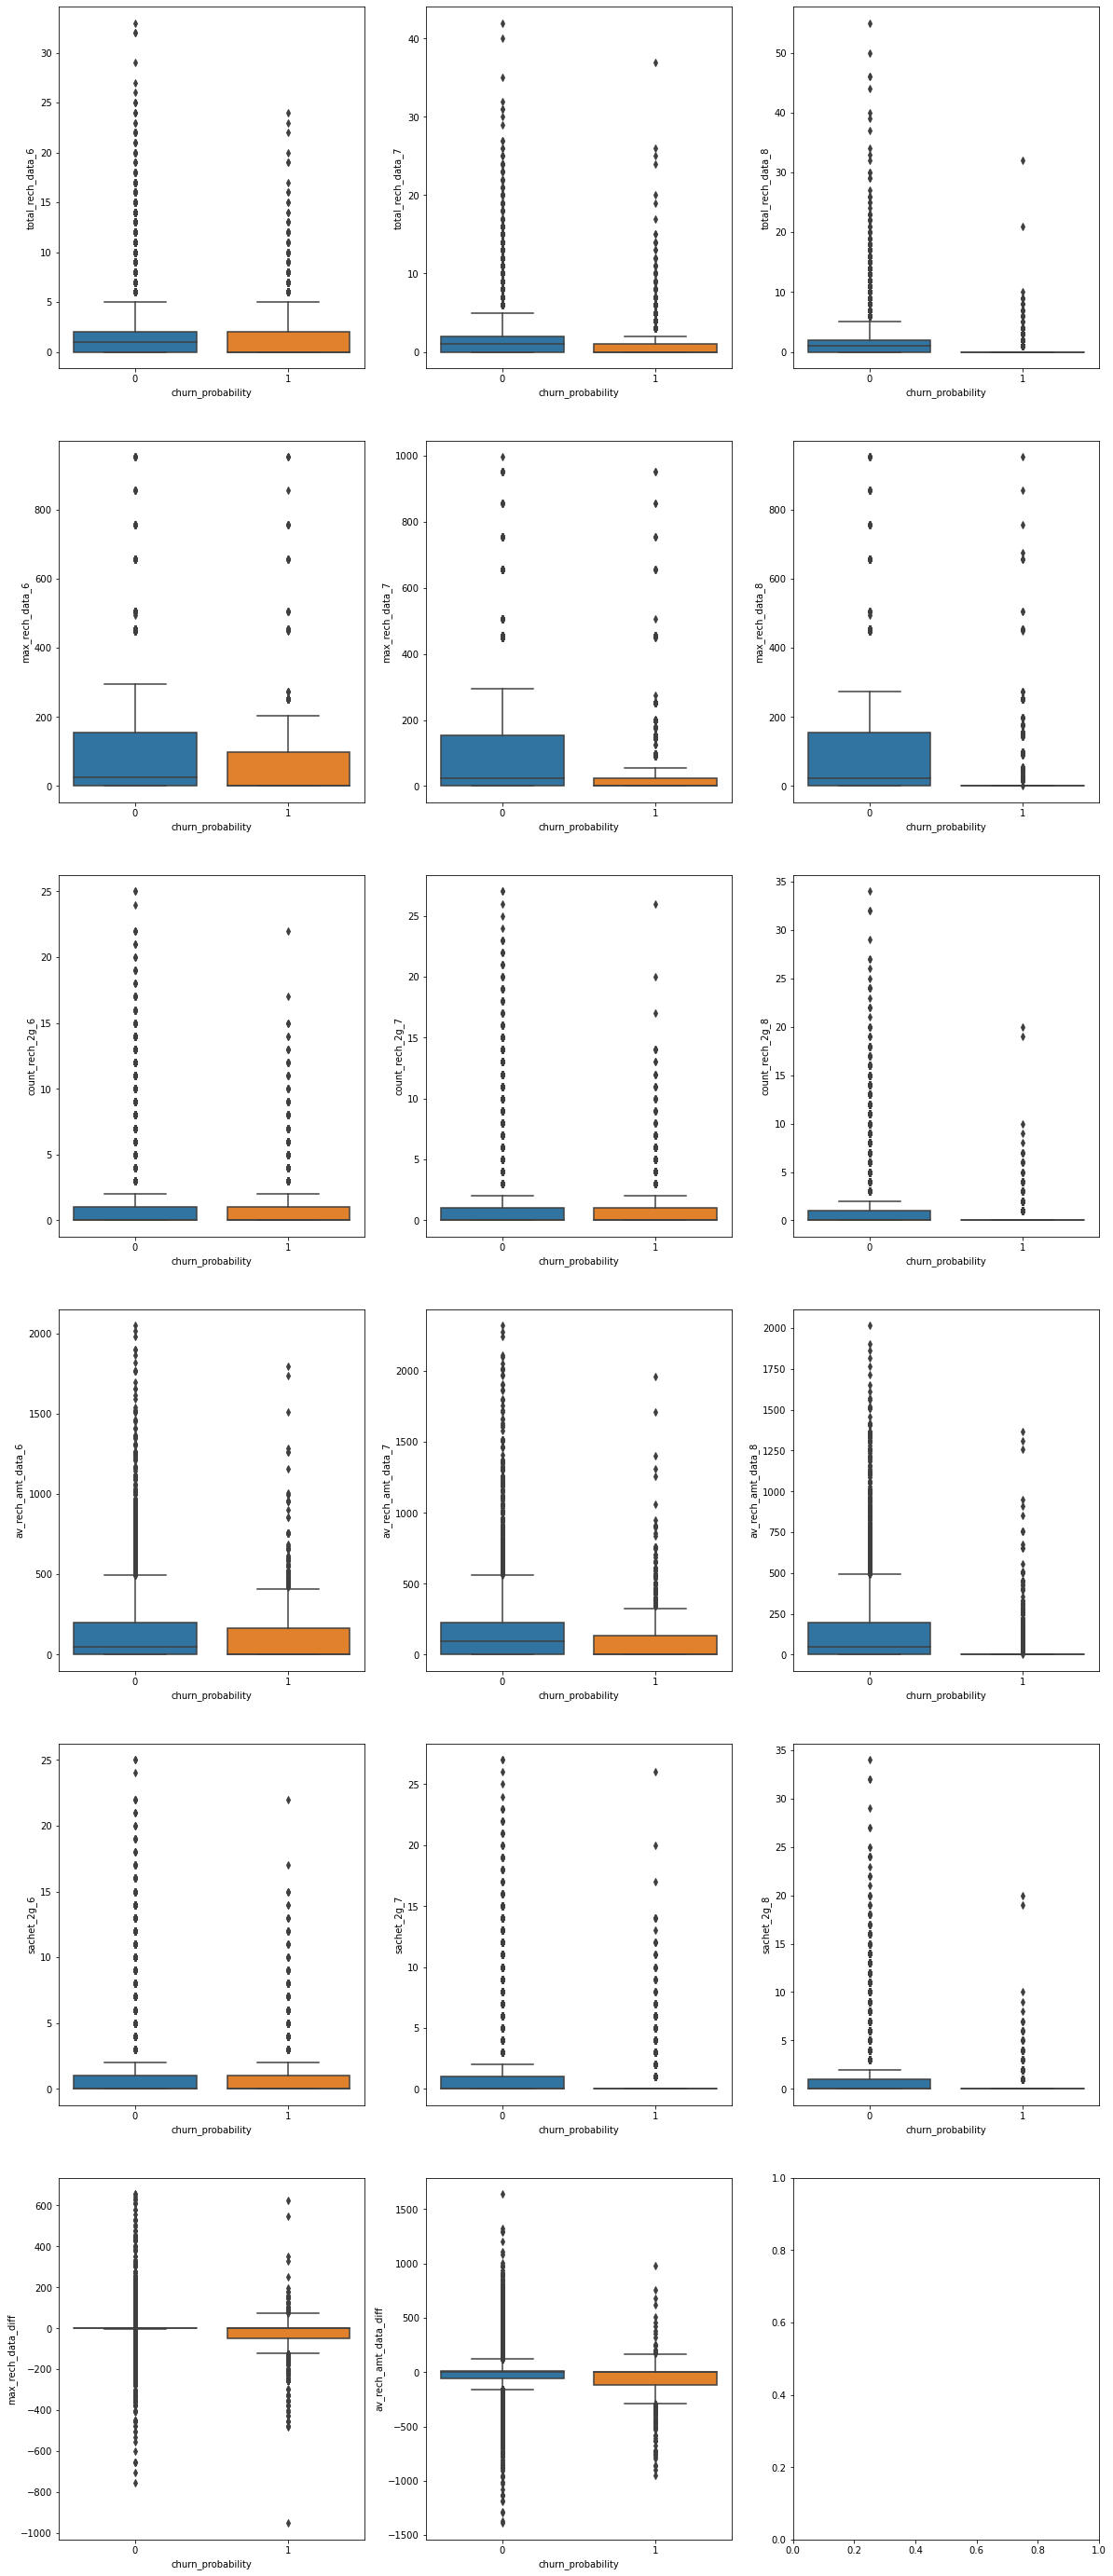

In [94]:
# For the following feature we can see some change when checked against churn probability

data_chart_cols = [ 'total_rech_data_6','total_rech_data_7','total_rech_data_8',
                    'max_rech_data_6','max_rech_data_7','max_rech_data_8',
                    'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
                    'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8',
                    'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                    'max_rech_data_diff','av_rech_amt_data_diff'
                
                ]

fig, axs = plt.subplots(6,3,figsize=(20,50))
j=0
for i in data_chart_cols:
    if(j>=3):
        k=j%3
    else:
        k=j
    sns.boxplot(Telecom_df_filtered['churn_probability'],Telecom_df_filtered[i],ax=axs[j//3][k])
    j+=1
fig.show()

- Following variables are decreasing across the months for churned customers
   - Total recharge data.
   - Maximum recharge data.
   - Count of recharge for 2g data
   - Average recharge amount data.
   - sachet data for 2g
   - Maximum recharge data difference between Aug month and Average of June and July month.
   - Average recharge data difference between Aug month and Average of June and July month.

#### Other features

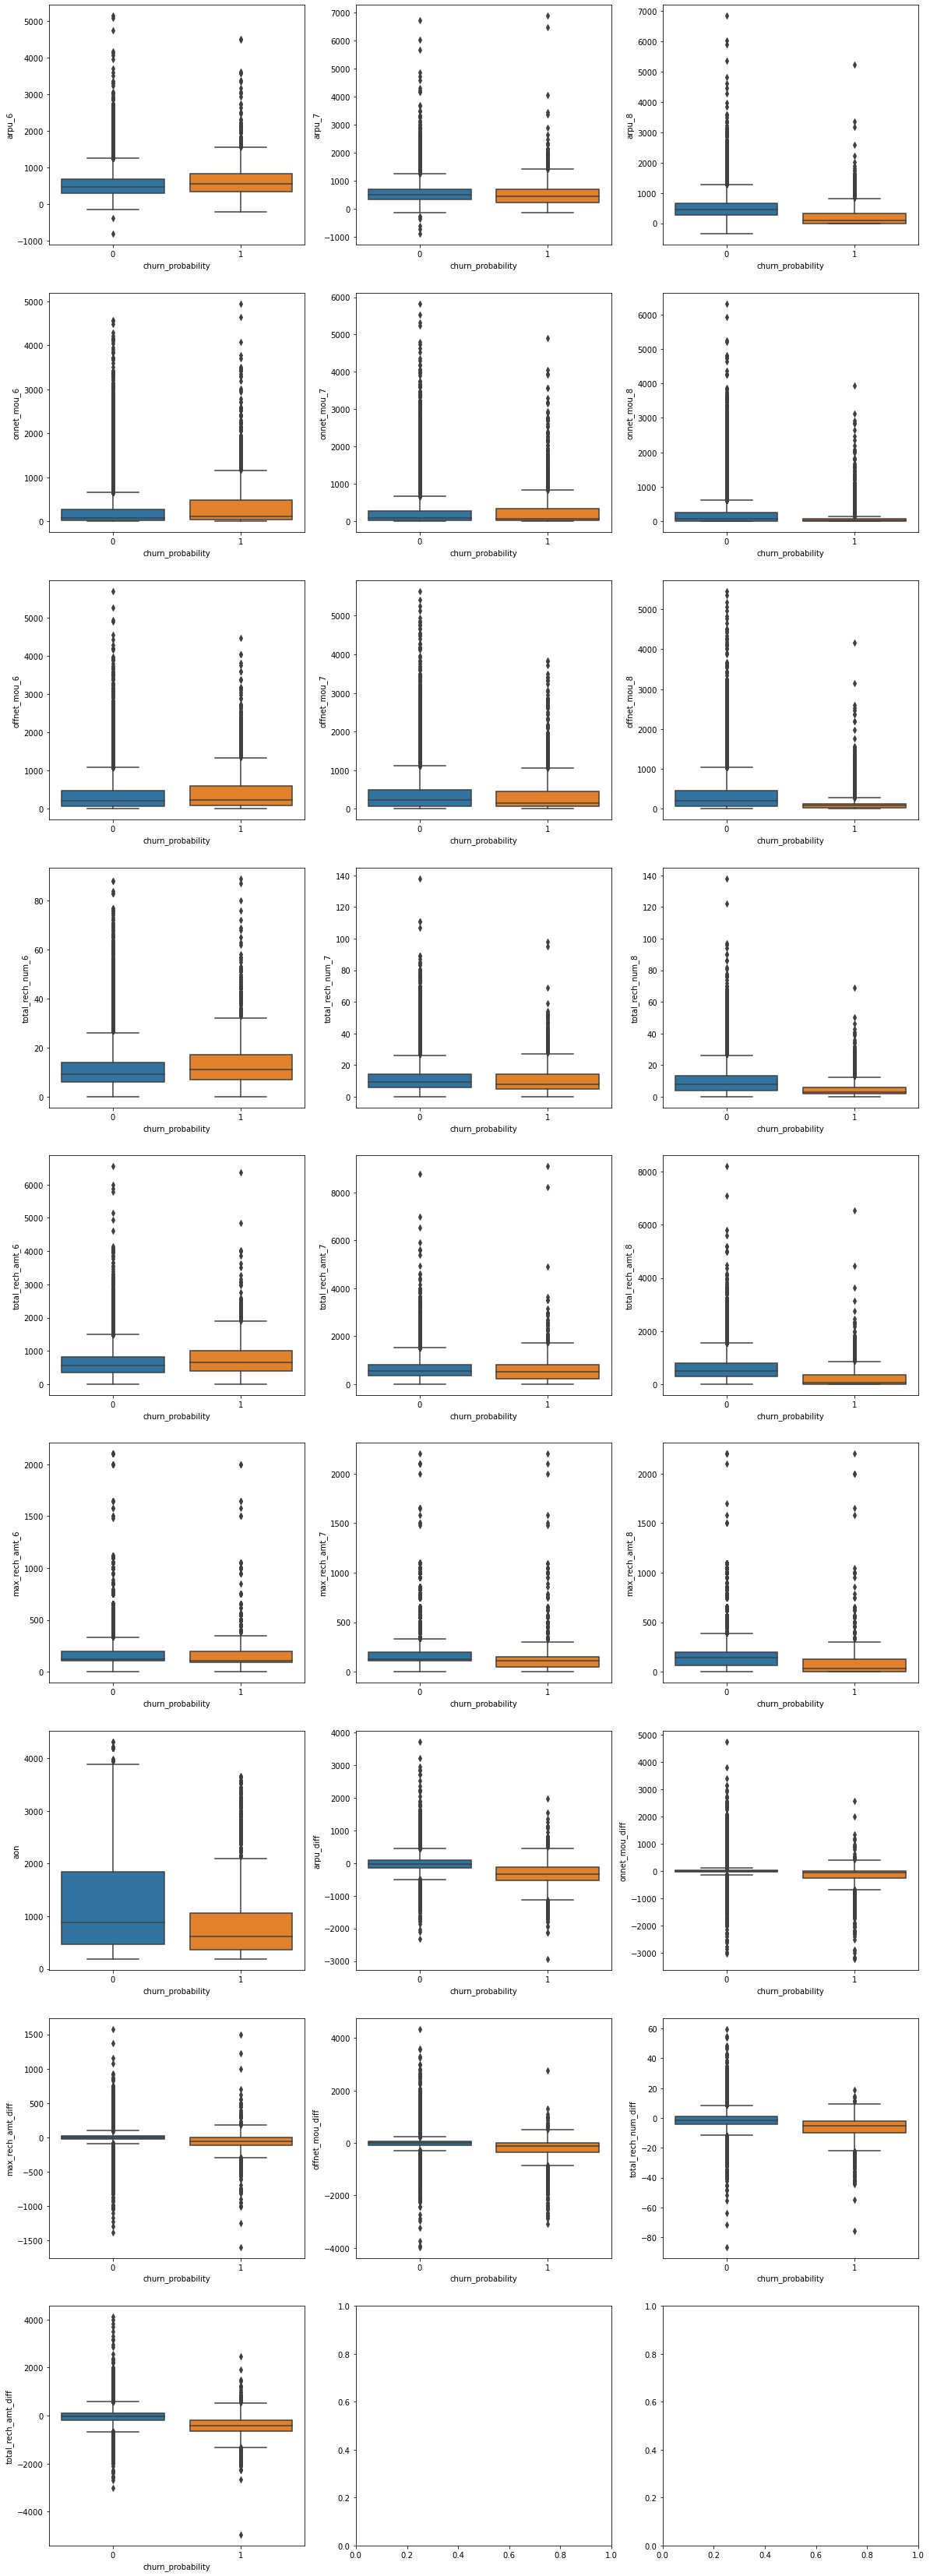

In [95]:
# For the following feature we can see some change when checked against churn probability

other_chart_cols = [ 'arpu_6','arpu_7','arpu_8',
                    'onnet_mou_6','onnet_mou_7','onnet_mou_8',
                     'offnet_mou_6','offnet_mou_7','offnet_mou_8',
                    'total_rech_num_6','total_rech_num_7','total_rech_num_8',
                    'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8',
                    'max_rech_amt_6','max_rech_amt_7','max_rech_amt_8',
                    'aon','arpu_diff','onnet_mou_diff','max_rech_amt_diff',
                    'offnet_mou_diff','total_rech_num_diff','total_rech_amt_diff',
                    ]

fig, axs = plt.subplots(9,3,figsize=(20,60))
j=0
for i in other_chart_cols:
    if(j>=3):
        k=j%3
    else:
        k=j
    sns.boxplot(Telecom_df_filtered['churn_probability'],Telecom_df_filtered[i],ax=axs[j//3][k])
    j+=1
fig.show()

- Following variables are decreasing across the months for churned customers
  - Average revenue per user.
  - On network minutes of usage.
  - off network minutes of usage.
  - Total recharge number.
  - Total recharge amount.
  - Maximum recharge amount.
  - Maximum recharege amount difference between Aug month and Average of June and July month.
  - onnet minutes of usage difference between Aug month and Average of June and July month.
  - offnet minutes of usage difference between Aug month and Average of June and July month.
  - total recharege number difference between Aug month and Average of June and July month.
  - totatl recharge amount difference between Aug month and Average of June and July month.
  

- Customer who has less tenure with operator are chruning more.
  
  

### Correlation of each feature against churn probability

Text(0.5, 1.0, 'Features Correlating with Churn variable')

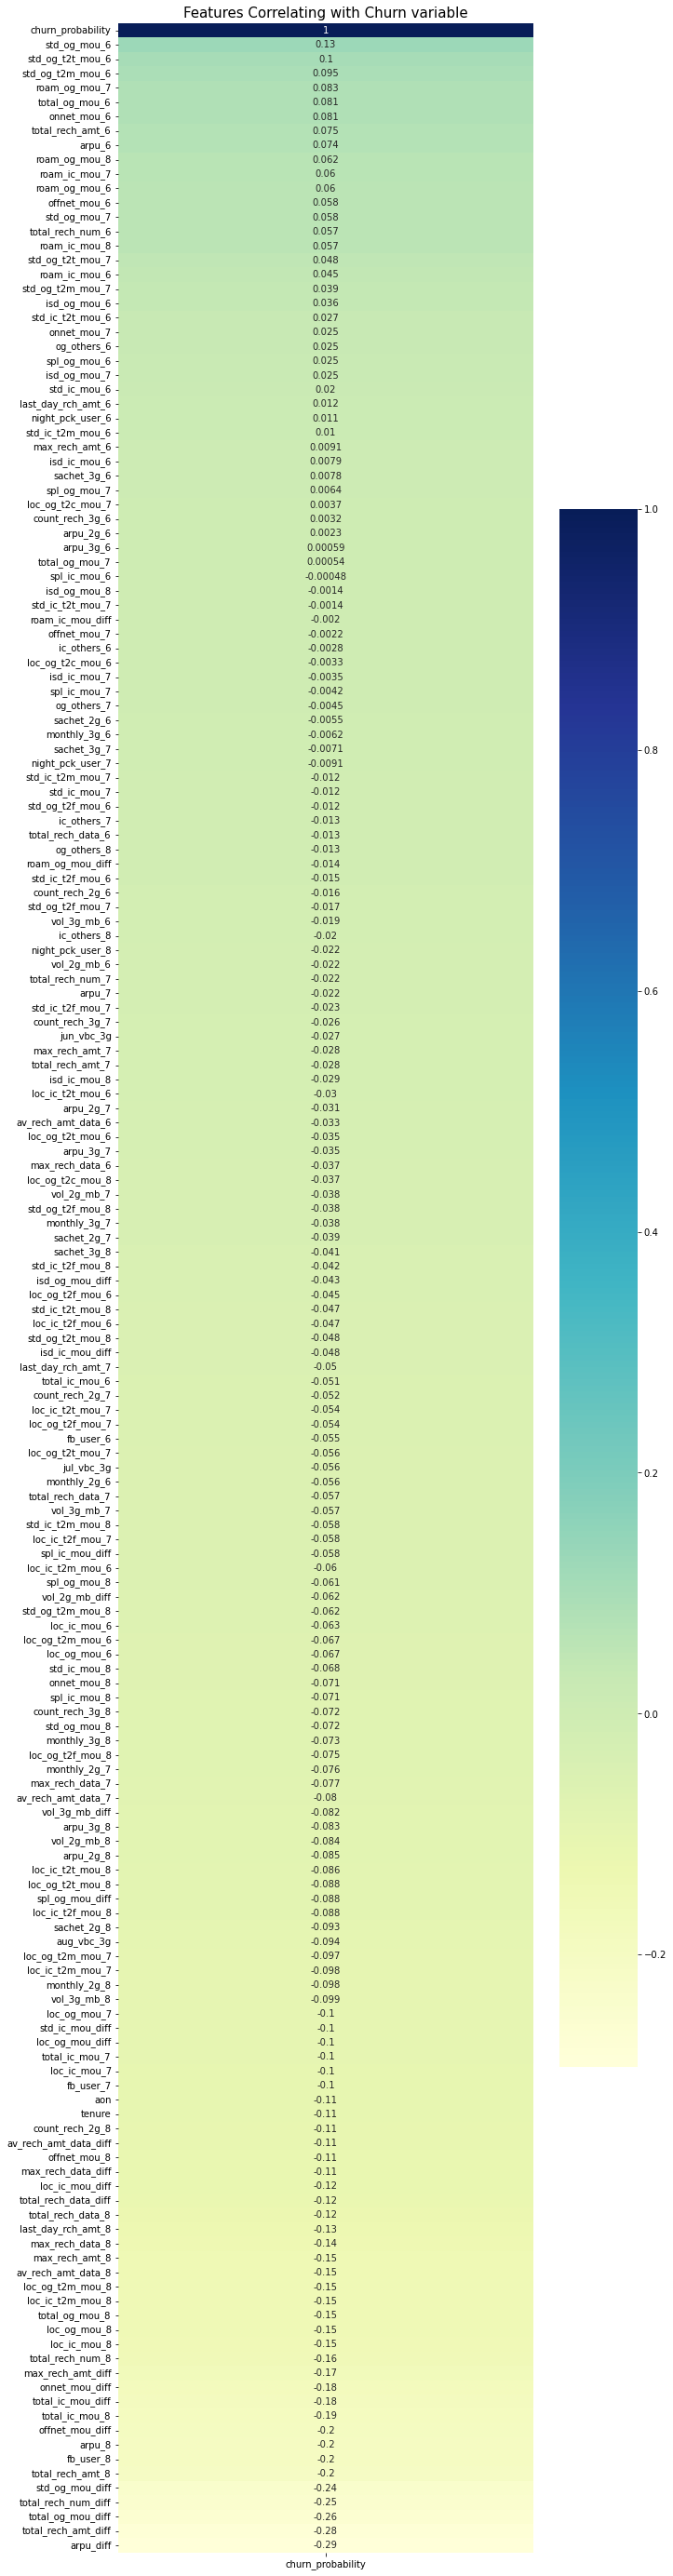

In [96]:
Telecom_df_filtered['churn_probability'] = Telecom_df_filtered['churn_probability'].astype("int")
plt.figure(figsize=(10,50))
heatmap_churn = sns.heatmap(Telecom_df_filtered.corr()[['churn_probability']].sort_values(ascending=False, by='churn_probability'),annot=True, cmap='YlGnBu')
heatmap_churn.set_title("Features Correlating with Churn variable", fontsize=15)

In [97]:
Telecom_df_filtered.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20764 entries, 0 to 21012
Data columns (total 185 columns):
 #    Column                    Non-Null Count  Dtype   
---   ------                    --------------  -----   
 0    arpu_6                    20764 non-null  float64 
 1    arpu_7                    20764 non-null  float64 
 2    arpu_8                    20764 non-null  float64 
 3    onnet_mou_6               20764 non-null  float64 
 4    onnet_mou_7               20764 non-null  float64 
 5    onnet_mou_8               20764 non-null  float64 
 6    offnet_mou_6              20764 non-null  float64 
 7    offnet_mou_7              20764 non-null  float64 
 8    offnet_mou_8              20764 non-null  float64 
 9    roam_ic_mou_6             20764 non-null  float64 
 10   roam_ic_mou_7             20764 non-null  float64 
 11   roam_ic_mou_8             20764 non-null  float64 
 12   roam_og_mou_6             20764 non-null  float64 
 13   roam_og_mou_7             207

In [98]:
# All the columns added for analysis and date will be dropped.

unwantedCols = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8',
'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','tenure','tenure_range',
'total_rech_data_group_8','total_rech_num_group_8']

Telecom_df_filtered.drop(unwantedCols,axis=1,inplace=True)

In [99]:
Telecom_df_filtered.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20764 entries, 0 to 21012
Data columns (total 175 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    arpu_6                 20764 non-null  float64
 1    arpu_7                 20764 non-null  float64
 2    arpu_8                 20764 non-null  float64
 3    onnet_mou_6            20764 non-null  float64
 4    onnet_mou_7            20764 non-null  float64
 5    onnet_mou_8            20764 non-null  float64
 6    offnet_mou_6           20764 non-null  float64
 7    offnet_mou_7           20764 non-null  float64
 8    offnet_mou_8           20764 non-null  float64
 9    roam_ic_mou_6          20764 non-null  float64
 10   roam_ic_mou_7          20764 non-null  float64
 11   roam_ic_mou_8          20764 non-null  float64
 12   roam_og_mou_6          20764 non-null  float64
 13   roam_og_mou_7          20764 non-null  float64
 14   roam_og_mou_8          20764 non-nul

## Splitting the Data into Training and Testing Sets<a class="anchor" id="Split"></a>

In [100]:
# Spliting to X and y
y= Telecom_df_filtered.pop('churn_probability')

X = Telecom_df_filtered

In [101]:
print(X.shape,y.shape)

(20764, 174) (20764,)


In [102]:
#Using train_test_split from sklearn we split the data into train and test set in 7:3 ratio

from sklearn.model_selection import train_test_split

# Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)


In [103]:
print(X_train.shape,X_test.shape)

(14534, 174) (6230, 174)


### Scaling the feature

In [104]:
# scaling the features - necessary before using model creation

from sklearn.preprocessing import StandardScaler

cols = X_train.columns
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = cols

cols = X_test.columns
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = cols

In [105]:
print(X_train.shape,X_test.shape)

(14534, 174) (6230, 174)


## Model Building and Evaluation

In [106]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(random_state=42)

pca.fit(X_train)

PCA(random_state=42)

In [107]:
pca.components_

array([[-7.99431618e-02, -8.16339716e-02, -5.97921818e-02, ...,
        -1.95497635e-02, -1.00502813e-02, -2.94557270e-03],
       [ 1.35762517e-01,  1.52786290e-01,  1.70042421e-01, ...,
         2.69895477e-02,  1.67827982e-02,  2.52718925e-02],
       [ 7.74066765e-02,  1.11512722e-01,  1.10449971e-01, ...,
         1.82506757e-02,  1.64908586e-02,  1.59610811e-02],
       ...,
       [-0.00000000e+00, -2.92300906e-16,  1.57829186e-16, ...,
        -7.15732405e-02, -4.31695077e-02, -1.44983231e-03],
       [ 0.00000000e+00, -1.35308431e-16, -4.76444444e-17, ...,
         2.13890980e-02,  3.17109923e-02,  2.42943066e-02],
       [-3.31128720e-01, -3.35991017e-01,  6.99370429e-01, ...,
         1.55539644e-15, -2.18683578e-16, -2.31802424e-16]])

In [108]:
pca.explained_variance_ratio_

array([1.01292530e-01, 8.56234781e-02, 5.76098405e-02, 5.01625316e-02,
       4.15288103e-02, 3.29499127e-02, 2.66057441e-02, 2.56677619e-02,
       2.28034437e-02, 2.20408662e-02, 1.96698261e-02, 1.84202913e-02,
       1.72366550e-02, 1.70195089e-02, 1.64470668e-02, 1.53093113e-02,
       1.46662784e-02, 1.44719480e-02, 1.37065421e-02, 1.36310488e-02,
       1.31540276e-02, 1.26544123e-02, 1.16308277e-02, 1.08136030e-02,
       1.03964215e-02, 1.02073962e-02, 9.93325087e-03, 9.88507195e-03,
       9.74095124e-03, 9.49855722e-03, 9.32108416e-03, 9.21600749e-03,
       8.71465294e-03, 8.24483047e-03, 8.00695747e-03, 7.87468912e-03,
       7.45778636e-03, 7.37984322e-03, 7.19449644e-03, 6.95104215e-03,
       6.71636074e-03, 6.52648459e-03, 6.38234931e-03, 6.04034134e-03,
       5.67917534e-03, 5.14663755e-03, 5.07718585e-03, 4.80831464e-03,
       4.73623045e-03, 4.59844081e-03, 4.54918102e-03, 4.44974703e-03,
       4.21871252e-03, 4.15758430e-03, 4.05498259e-03, 3.91354385e-03,
      

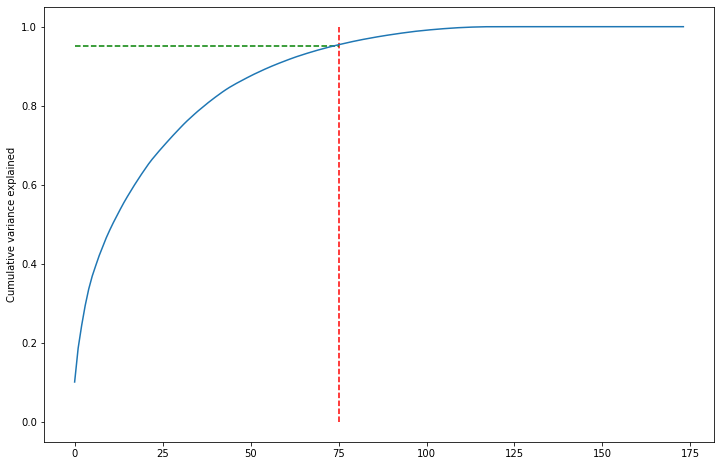

In [109]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.vlines(x=75, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=75, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [110]:
from sklearn.decomposition import IncrementalPCA

pca_final = IncrementalPCA(n_components=75)
X_train_pca = pca_final.fit_transform(X_train)
X_train_pca.shape


(14534, 75)

In [111]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(6230, 75)

In [112]:
from sklearn.linear_model import LogisticRegression

learner_pca = LogisticRegression()

model_pca = learner_pca.fit(X_train_pca, y_train)

In [113]:
y_train_pred_proba = model_pca.predict_proba(X_train_pca)

In [114]:
y_train_pred_final = pd.DataFrame({'Churned':y_train.values.reshape(-1), 'Churned_Prob':y_train_pred_proba[:,1].reshape(-1)})

In [115]:
y_train_pred_final

,Churned,Churned_Prob
0,0,0.000344
1,0,0.017829
2,1,0.192434
3,0,0.000806
4,0,0.045507
...,...,...
14529,0,0.111562
14530,0,0.039302
14531,0,0.011740
14532,0,0.170471


In [116]:
#Optimal cut-off point

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churned_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churned,Churned_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.000344,1,0,0,0,0,0,0,0,0,0
1,0,0.017829,1,0,0,0,0,0,0,0,0,0
2,1,0.192434,1,1,0,0,0,0,0,0,0,0
3,0,0.000806,1,0,0,0,0,0,0,0,0,0
4,0,0.045507,1,0,0,0,0,0,0,0,0,0


In [117]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churned, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.083803  1.000000  0.000000
0.1   0.1  0.831017  0.810345  0.832908
0.2   0.2  0.903674  0.715107  0.920922
0.3   0.3  0.923215  0.604269  0.952388
0.4   0.4  0.928650  0.458128  0.971688
0.5   0.5  0.925416  0.261084  0.986182
0.6   0.6  0.921770  0.134647  0.993767
0.7   0.7  0.919430  0.063218  0.997747
0.8   0.8  0.918398  0.031199  0.999549
0.9   0.9  0.917366  0.014778  0.999925


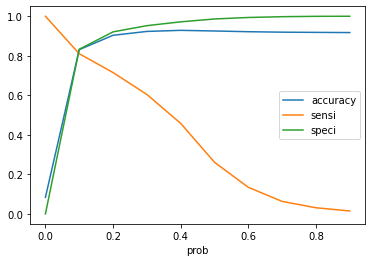

In [118]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [119]:
y_train_pred_final['final_Predicted'] = y_train_pred_final.Churned_Prob.map( lambda x: 1 if x > 0.1 else 0)

y_train_pred_final.head()

,Churned,Churned_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_Predicted
0,0,0.000344,1,0,0,0,0,0,0,0,0,0,0
1,0,0.017829,1,0,0,0,0,0,0,0,0,0,0
2,1,0.192434,1,1,0,0,0,0,0,0,0,0,1
3,0,0.000806,1,0,0,0,0,0,0,0,0,0,0
4,0,0.045507,1,0,0,0,0,0,0,0,0,0,0


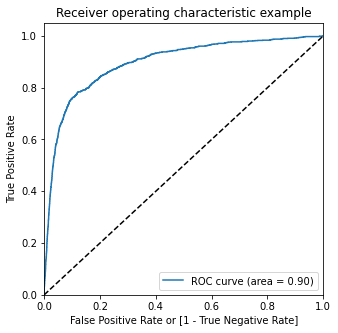

In [120]:
#ROC curve

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churned, y_train_pred_final.Churned_Prob, drop_intermediate = False )

draw_roc(y_train_pred_final.Churned, y_train_pred_final.Churned_Prob)

In [121]:

confusion = metrics.confusion_matrix(y_train_pred_final['Churned'], y_train_pred_final['final_Predicted'] ) 
print(confusion)

[[11091  2225]
 [  231   987]]


In [122]:
# Actual/Predicted       not_churn                         churn 
# not_churn                13132                            184 
# churn                     896                             322


TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives



In [123]:
# Let's see the sensitivity of our logistic regression model 
(TP / float(TP+FN)).round(2)

0.81

In [124]:
y_test_pred_proba = model_pca.predict_proba(X_test_pca)

In [125]:
y_test_pred_final = pd.DataFrame({'Churned':y_test.values.reshape(-1), 'Churned_Prob':y_test_pred_proba[:,1].reshape(-1)})

In [126]:
y_test_pred_final['final_Predicted'] = y_test_pred_final.Churned_Prob.map( lambda x: 1 if x > 0.1 else 0)

y_test_pred_final.head()

,Churned,Churned_Prob,final_Predicted
0,0,0.017257,0
1,0,0.023615,0
2,0,0.173413,1
3,0,0.004158,0
4,0,0.076028,0


In [127]:

confusion = metrics.confusion_matrix(y_test_pred_final['Churned'], y_test_pred_final['final_Predicted'] ) 
print(confusion)

[[4818  913]
 [ 105  394]]


In [128]:
# Actual/Predicted       not_churn                         churn 
# not_churn                13132                            184 
# churn                     896                             322


TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives



In [129]:
# Let's see the sensitivity of our logistic regression model 
(TP / float(TP+FN)).round(2)

0.79